# Software Bug Prediction

### Dataset:
The dataset is collected at the University of Geneva in Switzerland related to the bug prediction dataset. It contains data about the following software systems:
    - Eclipse JDT Core
    - Eclipse PDE UI
    - Equinox Framework
    - Lucene
    - Mylyn
    
### Objective:
Software success depends heavily on the ability of maintaining the software and ensuring that the software is released with minimal number of issues. Knowing in advance an estimation of possibile bugs in the software will mitagate some of the risks after the software is released. Our main objective is to be able to predict in advance the number of bugs in the software using the software data itself such as the number of lines of code, number of methods, number of attributes, and other important software properties. This is an overview of our objectives in details:
- Data Analysis
- Data preprocessing
- Data visualization
- Advanced EDA and visulaization using ML/D-reduction algorithms
- hyper-parameter tuning and solving the imbalance problem
    - Classifying data where the classes are: no bugs, 1 bug, or > 2 bugs
    - Classifying data where the classes are: no bugs, > 0 bugs

### Outline:
- import
- data cleaning
- EDA and visualization
    - descriptive statistics
    - correlation matrix
    - feature importance (Lasso)
    - feature importance (RFC)
    - kernal density estimation
    - 3D scatter cross plots
    - UMAP dimensionality reduction
    - PCA dimensionality reduction
    - clustering analysis
   
   
- Base Line Classifier
    - Accuacy
    - ROC
    - F-1 Score
    - Confusion Matrix
    - Area Under the Curve of ROC Viz
    
    
- first stage modeling
    - hyper-parameter tuning model optimization
    - dimensionality reduction
    
    
- evaluation
    - Accuacy
    - ROC
    - F-1 Score
    - Confusion Matrix
    - Area Under the Curve of ROC Viz
    
    
- second stage modeling (data-driven model optimization to tackle imbalance)
    - Under Sampling
    - Over Sampling
    - Feature Selection


- evaluation
    - Accuacy
    - ROC
    - F-1 Score
    
    
- models quality metrics table
    - Multi
        - Accuacy (All and Best)
        - ROC (All and Best)
        - F-1 Score (All and Best)
    - Binary
        - Accuacy (All and Best)
        - ROC (All and Best)
        - F-1 Score (All and Best)

In [ ]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 5)

from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, f1_score

from sklearn.preprocessing import LabelBinarizer

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

!pip install umap-learn
import umap.umap_ as umap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00


# Import

In [ ]:
eclipse_jdt = pd.read_csv("single-version-ck-oo.csv")
eclipse_pdt = pd.read_csv("single-version-ck-oo-pde.csv")
equinox = pd.read_csv("single-version-ck-oo-equinox.csv")
lucene = pd.read_csv("single-version-ck-oo-lucene.csv")
mylyn = pd.read_csv("single-version-ck-oo-mylyn.csv")
eclipse_jdt = eclipse_jdt.iloc[:, :-5]
eclipse_pdt = eclipse_pdt.iloc[:, :-5]
equinox = equinox.iloc[:, :-5]
lucene = lucene.iloc[:, :-5]
mylyn = mylyn.iloc[:, :-5]

# Preprocessing & Analysis

In [ ]:
print("NaNs in eclipse_jdt", np.sum(np.sum(eclipse_jdt.isna(), axis=0)) )
print("NaNs in eclipse_pdt", np.sum(np.sum(eclipse_pdt.isna(), axis=0)) )
print("NaNs in equinox", np.sum(np.sum(equinox.isna(), axis=0)) )
print("NaNs in lucene", np.sum(np.sum(lucene.isna(), axis=0)) )
print("NaNs in mylyn", np.sum(np.sum(mylyn.isna(), axis=0)) )

# drop nans
eclipse_pdt.dropna(axis = 1, inplace=True)
equinox.dropna(axis = 1, inplace=True)
lucene.dropna(axis = 1, inplace=True)
mylyn.dropna(axis = 1, inplace=True)

NaNs in eclipse_jdt 0
NaNs in eclipse_pdt 0
NaNs in equinox 0
NaNs in lucene 0
NaNs in mylyn 0


### Note:
All Nans are added columns due to added commas (seperators) in each row

In [ ]:
print("Data Shapes:", eclipse_jdt.shape, eclipse_pdt.shape, equinox.shape, lucene.shape, mylyn.shape)
df = pd.concat([eclipse_jdt, eclipse_pdt, equinox, lucene, mylyn], ignore_index=True)
df.columns = df.columns.str.replace(' ', '')
print("Full dataframe shape:",df.shape, '\n')
print("Predictors:")
for name in df.columns.values[1:18].tolist():
    print(name, end=', ')
print("\n\nPredictable:", df.columns.values[18])
df.head()

Data Shapes: (997, 19) (1497, 19) (324, 19) (691, 19) (1862, 19)
Full dataframe shape: (5371, 19) 

Predictors:
cbo, dit, fanIn, fanOut, lcom, noc, numberOfAttributes, numberOfAttributesInherited, numberOfLinesOfCode, numberOfMethods, numberOfMethodsInherited, numberOfPrivateAttributes, numberOfPrivateMethods, numberOfPublicAttributes, numberOfPublicMethods, rfc, wmc, 

Predictable: bugs


,classname,cbo,dit,fanIn,fanOut,lcom,noc,numberOfAttributes,numberOfAttributesInherited,numberOfLinesOfCode,numberOfMethods,numberOfMethodsInherited,numberOfPrivateAttributes,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,rfc,wmc,bugs
0,org::eclipse::jdt::internal::core::search::ind...,9,2,1,9,15,0,1,8,122.0,6.0,19,0,0,1.0,5,34.0,20.0,0
1,org::eclipse::jdt::internal::compiler::codegen...,1,1,1,0,0,0,2,0,4.0,1.0,8,0,0,2.0,1,1.0,1.0,0
2,org::eclipse::jdt::internal::compiler::ast::AS...,114,1,102,18,190,6,131,249,484.0,20.0,8,0,1,3.0,19,156.0,176.0,1
3,org::eclipse::jdt::internal::compiler::lookup:...,5,6,1,4,10,0,0,61,33.0,5.0,207,0,0,0.0,4,18.0,12.0,0
4,org::eclipse::jdt::internal::eval::CodeSnippet...,23,2,1,22,820,0,7,416,673.0,41.0,8,0,2,7.0,1,174.0,115.0,0


In [ ]:
df.describe()

,cbo,dit,fanIn,fanOut,lcom,noc,numberOfAttributes,numberOfAttributesInherited,numberOfLinesOfCode,numberOfMethods,numberOfMethodsInherited,numberOfPrivateAttributes,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,rfc,wmc,bugs
count,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000,5371.000000
mean,9.650717,1.948985,4.077825,5.808229,131.440328,0.548687,5.648110,20.607522,119.126233,9.465649,25.673245,2.701545,1.515733,1.588903,6.271272,47.397133,28.291380,0.259914
std,15.430910,1.339559,12.763334,7.413065,1419.297581,2.320663,32.421878,75.447749,305.121926,13.519683,40.646291,5.005445,4.259624,30.836387,10.583760,100.978959,69.140371,0.880067
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000,0.000000,18.000000,3.000000,7.000000,0.000000,0.000000,0.000000,2.000000,8.000000,4.000000,0.000000
50%,6.000000,1.000000,1.000000,3.000000,15.000000,0.000000,2.000000,0.000000,47.000000,6.000000,12.000000,1.000000,0.000000,0.000000,4.000000,21.000000,11.000000,0.000000
75%,11.000000,2.000000,3.000000,8.000000,55.000000,0.000000,5.000000,2.000000,115.000000,11.000000,30.000000,3.000000,1.000000,0.000000,7.000000,51.000000,27.000000,0.000000
max,362.000000,9.000000,355.000000,93.000000,81003.000000,49.000000,2169.000000,563.000000,7509.000000,403.000000,602.000000,103.000000,111.000000,2168.000000,387.000000,2603.000000,1680.000000,28.000000


### Note:
- Values in columns are distributed with high standard deviation compared to others -> Scaling is needed if a distance-based model is used, but not now on the whole dataset to prevent data leakage.
- We do not need confusing variables such as the class name; We can use it as an index or discard it.


In [ ]:
# Shuffle data before removing classname to keep mapping
df = df.sample(frac=1.0)

# We do not need confusing variables such as the class name; We can use it as an index or leave it.
X = df.iloc[:, 1:-1]
y = df["bugs"]

print("X:", X.shape)
print("y:", y.shape)

X: (5371, 17)
y: (5371,)


In [ ]:
X.head()

,cbo,dit,fanIn,fanOut,lcom,noc,numberOfAttributes,numberOfAttributesInherited,numberOfLinesOfCode,numberOfMethods,numberOfMethodsInherited,numberOfPrivateAttributes,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,rfc,wmc
474,1,6,1,0,10,0,1,11,13.0,5.0,47,1,0,0.0,4,5.0,4.0
4261,9,3,0,9,78,0,7,0,164.0,13.0,14,7,7,0.0,6,64.0,23.0
4387,0,1,0,0,0,1,1,0,3.0,1.0,9,0,0,0.0,1,1.0,1.0
3798,1,1,0,1,0,0,1,0,14.0,1.0,0,0,0,0.0,1,7.0,4.0
3930,2,1,0,2,1,0,2,0,43.0,2.0,0,2,0,0.0,2,13.0,2.0


### Make Classes [0, 1, 2] Bugs

for Multi-classifiers; we will start with Task 2 first

In [ ]:
idxs = y.where(y > 2)
for i in idxs:
  y = y.replace(i, 2)

### Class Balance

Classes: [0, 1, 2]
Counts: [4518, 598, 255]


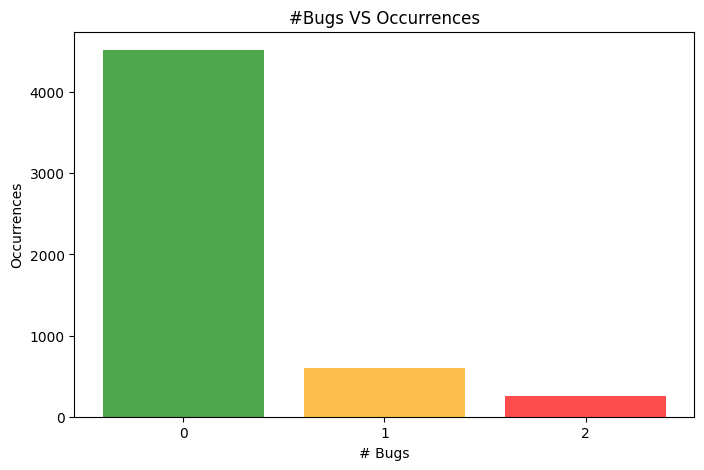

In [ ]:
unique, counts = np.unique(y, return_counts=True)
print("Classes:", unique.tolist())
print("Counts:", counts.tolist())

plt.bar(unique, counts, color=['g', 'orange', 'r'], alpha=0.7)
plt.title("#Bugs VS Occurrences")
plt.xticks(range(len(unique)))
plt.ylabel("Occurrences")
plt.xlabel("# Bugs");

### Note:
Based on these class balances, we have to be careful not to overfit or make the classifier favors "Class 0" unfairly

# More EDA on Training Set

### Note:
It is better to Leave-One-Out and do the EDA & some transoformational preprocessing so that we do not use our intuition and analysis from the test set  and be fooled by a high accuracy on a set that we have prepared our model for.

###### Example:
Feature Selection that is done on the whole dataset is a very pure data leakage. Your test set is not a test set if the model has already known what are the best features to use as predictors of the target value

###### Example:
Dimensionality reduction (such as PCA) that is done one the whole dataset means that you have leaked distributional information from the test set to the training set (e.g. Variance).

###### Example:
Scaling the dataset as a whole is needed but when you use the whole dataset for fitting the scalar, then data leakage has occured, if a blueprint dataset factor (e.g. variance, mean, minimum, maximum) is used

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5)
print("Train:", X_train.shape, y_train.shape,
      "Test:", X_test.shape, y_test.shape,
      "Cross Validation", X_cv.shape, y_cv.shape)

Train: (3759, 17) (3759,) Test: (806, 17) (806,) Cross Validation (806, 17) (806,)


Let's make sure that we have a similar class balance distribution

Classes: [0, 1, 2]
Counts: [3162, 409, 188]


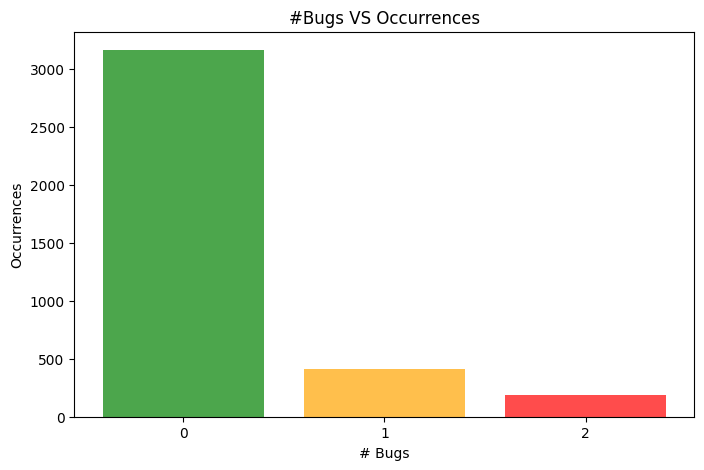

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
print("Classes:", unique.tolist())
print("Counts:", counts.tolist())

plt.bar(unique, counts, color=['g', 'orange', 'r'], alpha=0.7)
plt.title("#Bugs VS Occurrences")
plt.xticks(range(len(unique)))
plt.ylabel("Occurrences")
plt.xlabel("# Bugs");

##### Scaling Features

In [ ]:
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

data_for_viz = X_train_scaled.copy()
data_for_viz_unscaled = X_train.copy()

data_for_viz['Bugs'] = y_train.copy().tolist()
data_for_viz_unscaled['Bugs'] = y_train.copy().tolist()

In [ ]:
data_for_viz.head()

,cbo,dit,fanIn,fanOut,lcom,noc,numberOfAttributes,numberOfAttributesInherited,numberOfLinesOfCode,numberOfMethods,numberOfMethodsInherited,numberOfPrivateAttributes,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,rfc,wmc,Bugs
1027,-0.478405,-0.697323,-0.231881,-0.653499,-0.085594,-0.252181,-0.237804,-0.278059,-0.322640,-0.458480,-0.619383,-0.137161,-0.348314,-0.131244,-0.292611,-0.374890,-0.335392,0
5004,-0.050422,-0.697323,-0.231881,0.293182,-0.083804,-0.252181,0.125602,-0.278059,-0.076097,-0.389413,-0.403525,0.832719,0.117716,-0.131244,-0.378462,-0.071160,-0.087481,0
3013,-0.478405,0.776939,-0.304079,-0.518259,-0.087384,-0.252181,-0.383166,-0.239540,-0.237172,-0.596614,-0.043764,-0.525113,-0.348314,-0.131244,-0.550164,-0.298957,-0.252755,0
492,-0.172703,0.039808,-0.159684,0.022702,-0.083804,-0.252181,0.125602,-0.278059,-0.296342,-0.389413,-0.307589,0.444767,-0.348314,0.084097,-0.292611,-0.317940,-0.252755,0
1413,-0.417264,2.988332,-0.231881,-0.518259,-0.065903,-0.252181,-0.310485,1.134319,-0.289768,-0.044079,9.262079,-0.331137,-0.348314,-0.131244,0.222496,-0.289466,-0.266528,0


#### Correlation Matrix

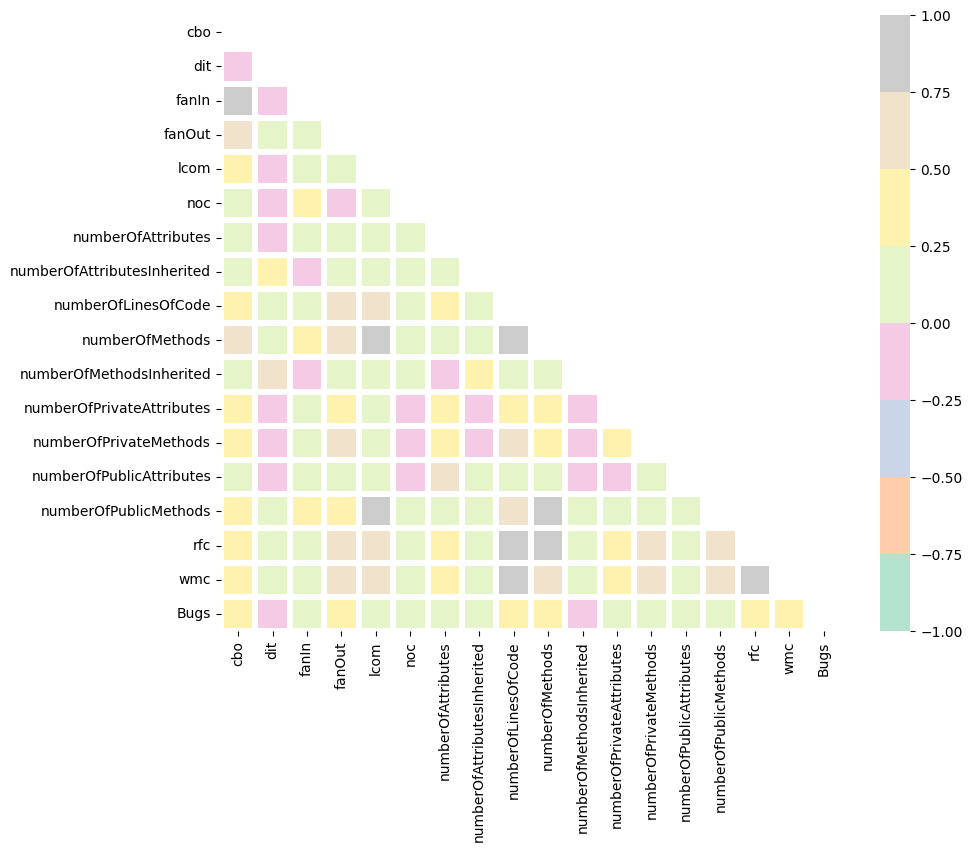

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))

corr = data_for_viz.corr()
mask = np.triu(corr)
sns.heatmap(corr, vmin=-1, vmax=1, center= 0, cmap= 'Pastel2', linewidths=3, ax=ax, mask=mask);

###### We can see that highest correlated variables with Bugs are:
1. cbo
    - is correlated with fanIn
    - is correlated with fanOut
2. fanout
    - is correlated with wmc
    - is correlated with rfc
    - is correlated with numberOfLinesOfCode
    - is correlated with numberOfMethods
3. numberOfLinesOfCode
    - is correlated with wmc
    - is correlated with rfc
    - is correlated with numberOfMethods
4. numberOfMethods
    - is correlated with wmc
    - is correlated with rfc
    - is correlated with numberOfPublicMethods
    
    - .
    - .
    - .
    

#### To sum up: There is a high correlation between:
    - Bugs
    - cbo
    - fanout
    - fanIn
    - wmc
    - rfc
    - numberOfLinesOfCode
    - numberOfMethods
    - numberOfPublicMethods
    - numberOfPrivateMethods

### Feature importance with Lasso regression

In [ ]:
lasso = Lasso()
lasso.fit(X_train,y_train)
coef = pd.Series(lasso.coef_, index = X_train.columns)

print("Discarded Features:", np.sum(lasso.coef_==0), "out of", len(X_train.columns))

Discarded Features: 14 out of 17


In [ ]:
coef = coef[coef != 0]

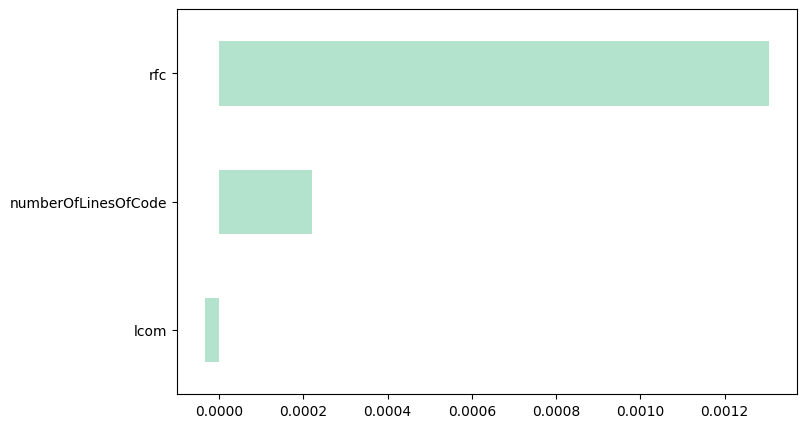

In [ ]:
coef.sort_values().plot(kind='barh', cmap="Pastel2");

### Feature importance with Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train);
coef_rfc = pd.Series(rfc.feature_importances_, index = X_train.columns)

In [ ]:
preds = rfc.predict(X_train)
print("accuracy score:", accuracy_score(y_train, preds))

accuracy score: 0.9962756052141527


### Note:
of course, the accuracy is going to be high on the same set that was trained on, we are just making sure that it has done a good job on predicting the training set and thus giving an accurate prediction of important features **based on the training set**

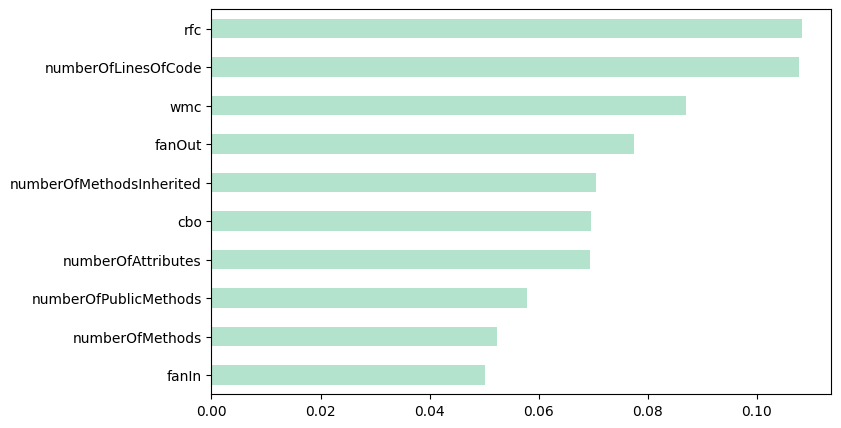

In [ ]:
coef_rfc.sort_values()[7:].plot(kind='barh', cmap="Pastel2");

#### Pick Features for DataViz
Let's now pick a couple of important features from our analysis with correlation matrix, lasso regression feature importance, and random forest classifier feature importance, we will go with:
    - rfc
    - cbo
    - fanOut
    - wmc
    - numberOfLinesOfCode
#### As these features are the most effective ones as predictors over our analysis
# Data Visualization   

In [ ]:
data_for_viz_unscaled.head()

,cbo,dit,fanIn,fanOut,lcom,noc,numberOfAttributes,numberOfAttributesInherited,numberOfLinesOfCode,numberOfMethods,numberOfMethodsInherited,numberOfPrivateAttributes,numberOfPrivateMethods,numberOfPublicAttributes,numberOfPublicMethods,rfc,wmc,Bugs
1027,2,1,1,1,3,0,2,0,20.0,3.0,0,2,0,0.0,3,8.0,4.0,0
5004,9,1,1,8,6,0,7,0,95.0,4.0,9,7,2,0.0,2,40.0,22.0,0
3013,2,3,0,2,0,0,0,3,46.0,1.0,24,0,0,0.0,0,16.0,10.0,0
492,7,2,2,6,6,0,7,0,28.0,4.0,13,5,0,2.0,3,14.0,10.0,0
1413,3,6,1,2,36,0,1,110,30.0,9.0,412,1,0,0.0,9,17.0,9.0,0


#### Pair Plots (Scatter)

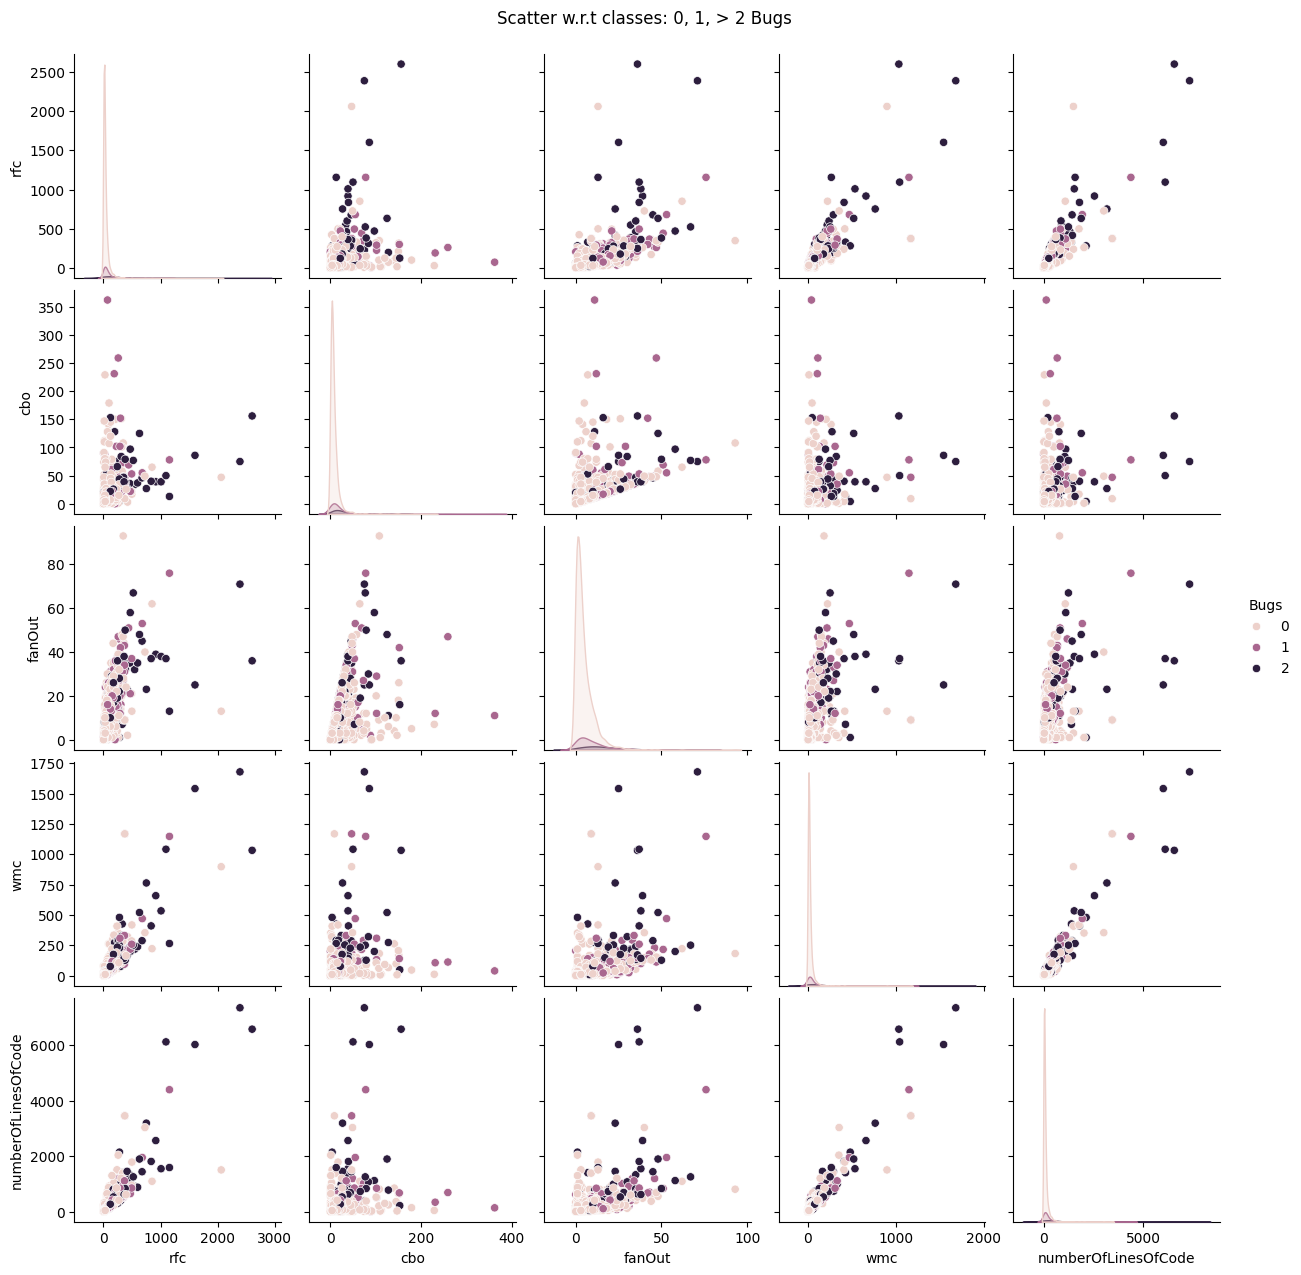

In [ ]:
for_pair_plot = data_for_viz_unscaled[['rfc', 'cbo', 'fanOut','wmc', 'numberOfLinesOfCode', 'Bugs']]
pairplot = sns.pairplot(for_pair_plot, hue="Bugs", vars=['rfc', 'cbo', 'fanOut', 'wmc', 'numberOfLinesOfCode']);
pairplot.fig.suptitle("Scatter w.r.t classes: 0, 1, > 2 Bugs", y=1.02);

### Kernal Density of Classes w.r.t one variable

<ipython-input-23-ea7bfc4ca0dc>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'rfc'], color='g', shade=True)
<ipython-input-23-ea7bfc4ca0dc>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'rfc'], color='orange', shade=True)
<ipython-input-23-ea7bfc4ca0dc>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'rfc'], color='r', shade=True)


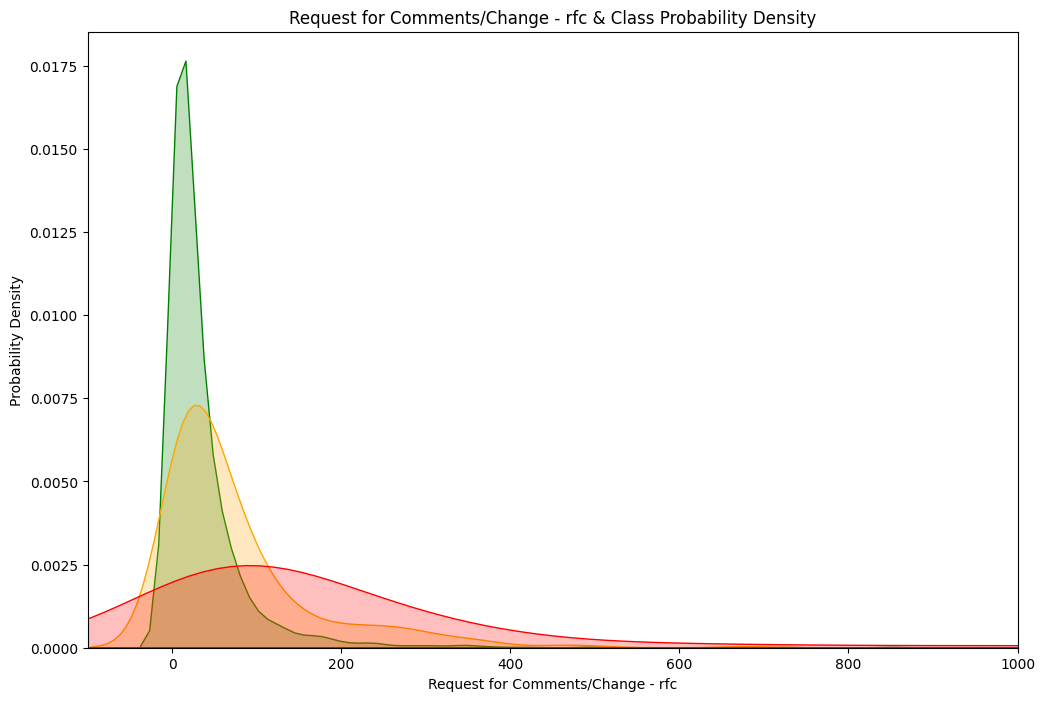

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'rfc'], color='g', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'rfc'], color='orange', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'rfc'], color='r', shade=True)

plt.xlabel('Request for Comments/Change - rfc')
plt.ylabel('Probability Density')
plt.title("Request for Comments/Change - rfc & Class Probability Density")

plt.xlim(-100, 1000);

<ipython-input-24-cc8063aafb69>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'cbo'], color='g', shade=True)
<ipython-input-24-cc8063aafb69>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'cbo'], color='orange', shade=True)
<ipython-input-24-cc8063aafb69>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'cbo'], color='r', shade=True)


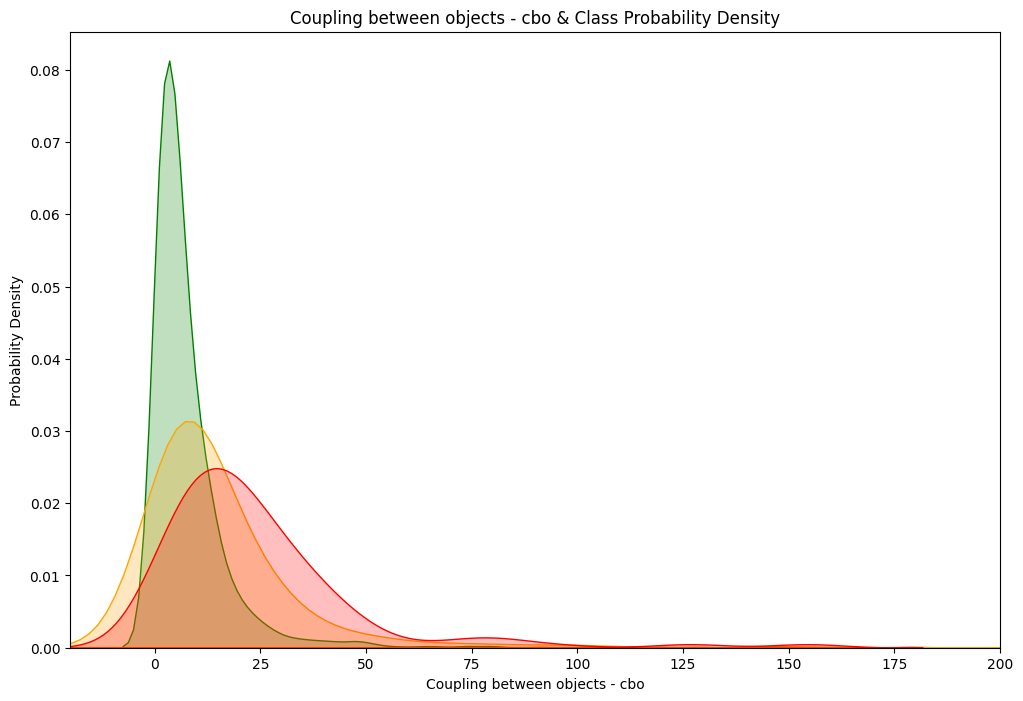

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'cbo'], color='g', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'cbo'], color='orange', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'cbo'], color='r', shade=True)

plt.xlabel('Coupling between objects - cbo')
plt.ylabel('Probability Density')
plt.title("Coupling between objects - cbo & Class Probability Density")

plt.xlim(-20, 200);

<ipython-input-25-2dc4225ba693>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'fanOut'], color='g', shade=True)
<ipython-input-25-2dc4225ba693>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'fanOut'], color='orange', shade=True)
<ipython-input-25-2dc4225ba693>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'fanOut'], color='r', shade=True)


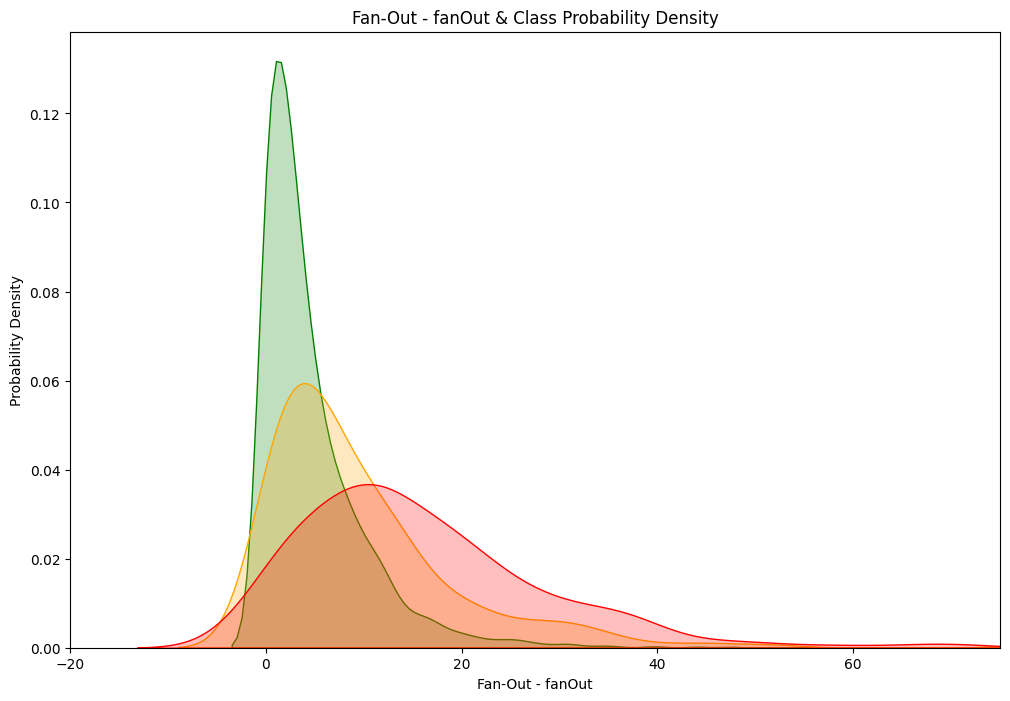

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'fanOut'], color='g', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'fanOut'], color='orange', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'fanOut'], color='r', shade=True)

plt.xlabel('Fan-Out - fanOut')
plt.ylabel('Probability Density')
plt.title("Fan-Out - fanOut & Class Probability Density")

plt.xlim(-20, 75);

<ipython-input-26-6975ab95e2f2>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'wmc'], color='g', shade=True)
<ipython-input-26-6975ab95e2f2>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'wmc'], color='orange', shade=True)
<ipython-input-26-6975ab95e2f2>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'wmc'], color='r', shade=True)


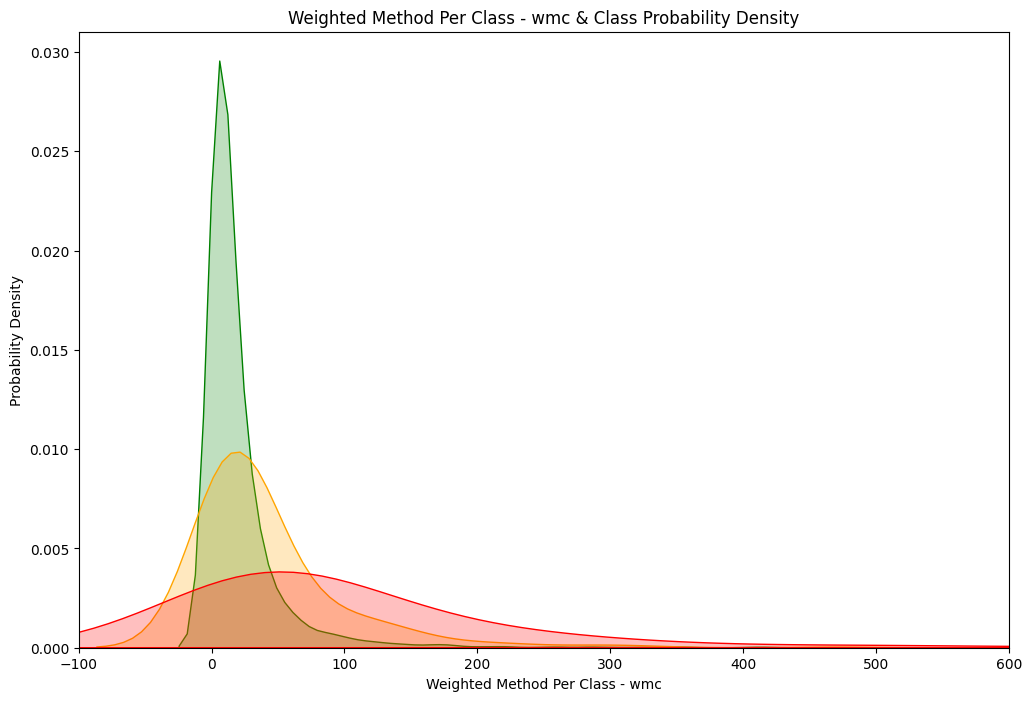

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'wmc'], color='g', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'wmc'], color='orange', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'wmc'], color='r', shade=True)

plt.xlabel('Weighted Method Per Class - wmc')
plt.ylabel('Probability Density')
plt.title("Weighted Method Per Class - wmc & Class Probability Density")

plt.xlim(-100, 600);

<ipython-input-27-c7c6ab6f9e37>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'numberOfLinesOfCode'], color='g', shade=True)
<ipython-input-27-c7c6ab6f9e37>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'numberOfLinesOfCode'], color='orange', shade=True)
<ipython-input-27-c7c6ab6f9e37>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'numberOfLinesOfCode'], color='r', shade=True)


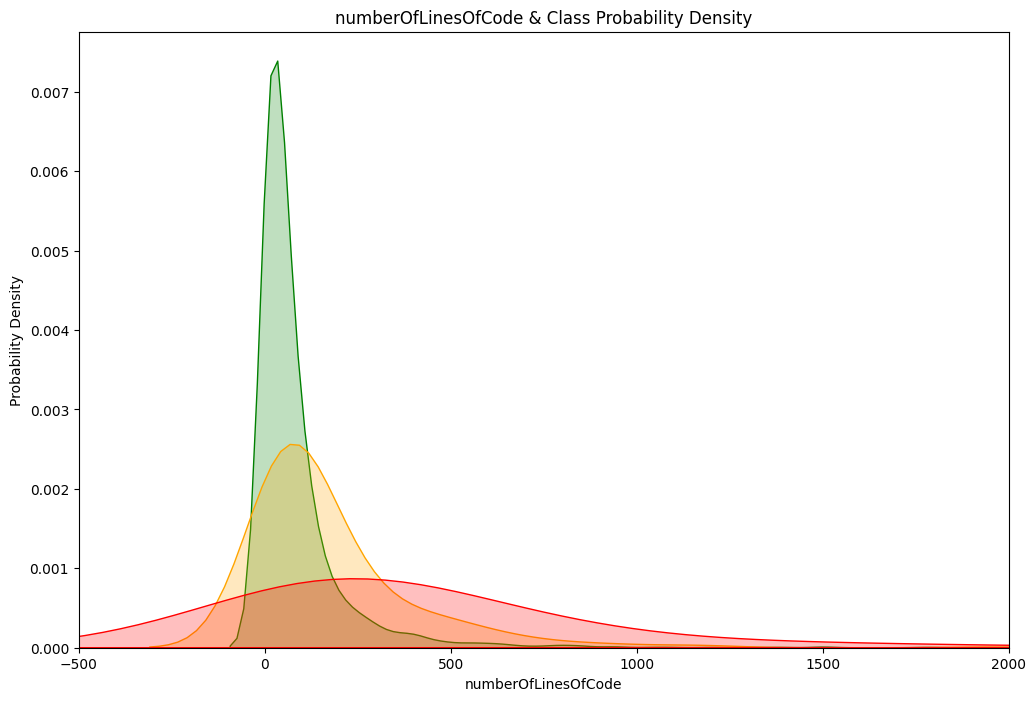

In [ ]:
fig = plt.figure(figsize=(12,8))
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'numberOfLinesOfCode'], color='g', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'numberOfLinesOfCode'], color='orange', shade=True)
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'numberOfLinesOfCode'], color='r', shade=True)

plt.xlabel('numberOfLinesOfCode')
plt.ylabel('Probability Density')
plt.title("numberOfLinesOfCode & Class Probability Density")
plt.xlim(-500, 2000);

## Observation:
It is very clear from all the plots above that the larger the number of negative properties (not necessarily negative but intuitively relates to a risk prone or a bug susceptible software property) the larger the probability of having more bugs.

# Clustering Analysis
### UMAP Dimensionality reduction algorithm
This is an alogorithm that was developed in 2018 which competes with state-of-the-art dimensionality reduction algorithms in its fast execution performance and the ability to project the dimensions without losing a lot of information.

Feel free to explore benchmarking against other algorithms here:
https://umap-learn.readthedocs.io/en/latest/benchmarking.html

*McInnes, Leland, Healy, John, & James. (2018, December 06). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. Retrieved from https://arxiv.org/abs/1802.03426*

In [ ]:
reducer = umap.UMAP(verbose=False)
embedding = reducer.fit_transform(X_train_scaled)
embedding.shape

(3759, 2)

In [ ]:
embedding = pd.DataFrame(embedding)
embedding.head()

,0,1
0,-1.732265,3.021939
1,1.162345,5.692909
2,5.965026,14.156964
3,1.345542,11.831008
4,6.450722,10.942096


#### Next plot is colored by K-Means predictions

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


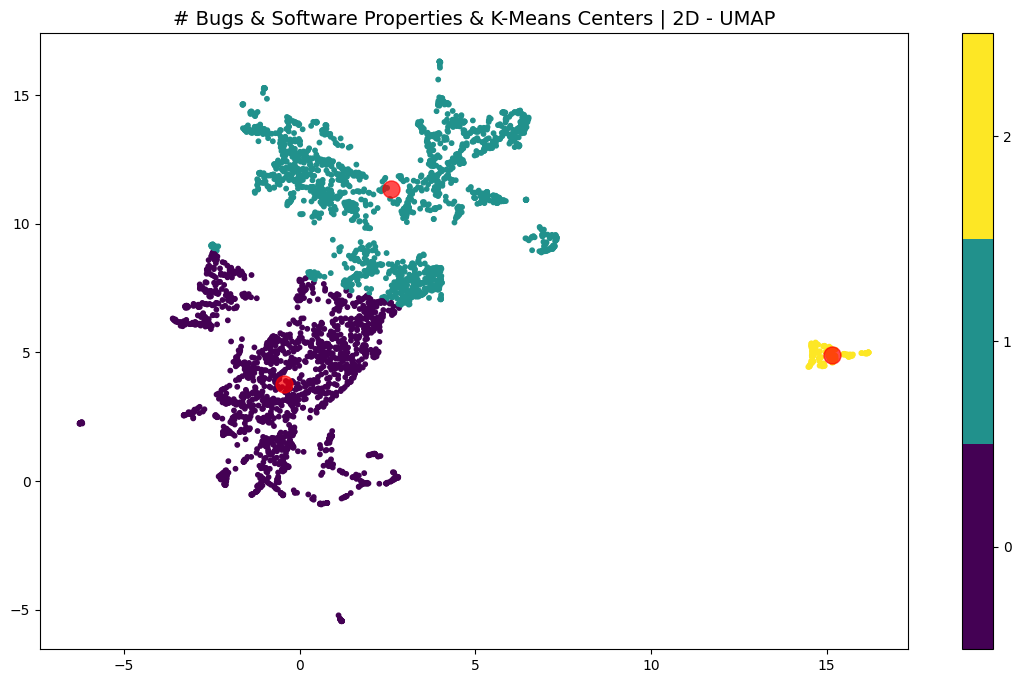

In [ ]:
kmeans_umap = KMeans(n_clusters=3)
kmeans_umap.fit(embedding)
preds_kmeans_umap = kmeans_umap.predict(embedding)

fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(embedding[0], embedding[1], c=preds_kmeans_umap, s=10, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(preds_kmeans_umap))

plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], c='red', s=150, alpha=0.7);

plt.title('# Bugs & Software Properties & K-Means Centers | 2D - UMAP', fontsize=14);

In [ ]:
print("K-Means Accuracy Score:", accuracy_score(preds_kmeans_umap, y_train))

K-Means Accuracy Score: 0.4714019686086725


### Note:
This accuracy on the training set is not a surprise! Take a look at the plot below.

Note that there is no relationship between the number of bugs and the clusters set by K-Means predictor. 0,1, and 2 in the plot are just the specified number of clusters for K-Means.

To clarify the confusion
#### Next Plot is colored by actual values (y_train) and K-Means centers are included

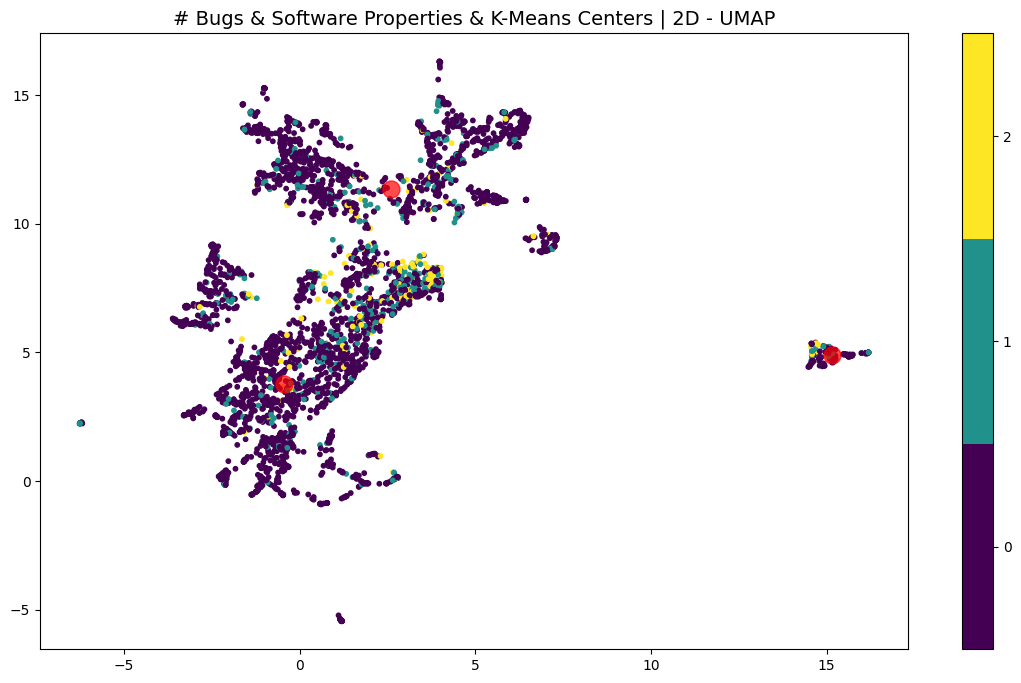

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(embedding[0], embedding[1], c=y_train, s=10, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(y_train))

plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], c='red', s=150, alpha=0.7);

plt.title('# Bugs & Software Properties & K-Means Centers | 2D - UMAP', fontsize=14);

### PCA Dimensionality reduction algorithm

#### Next plot is colored by actual values (y_train)
#### Note:
The plot was zoomed due to extreme outliers

In [ ]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)

principalComponents = pd.DataFrame(principalComponents)

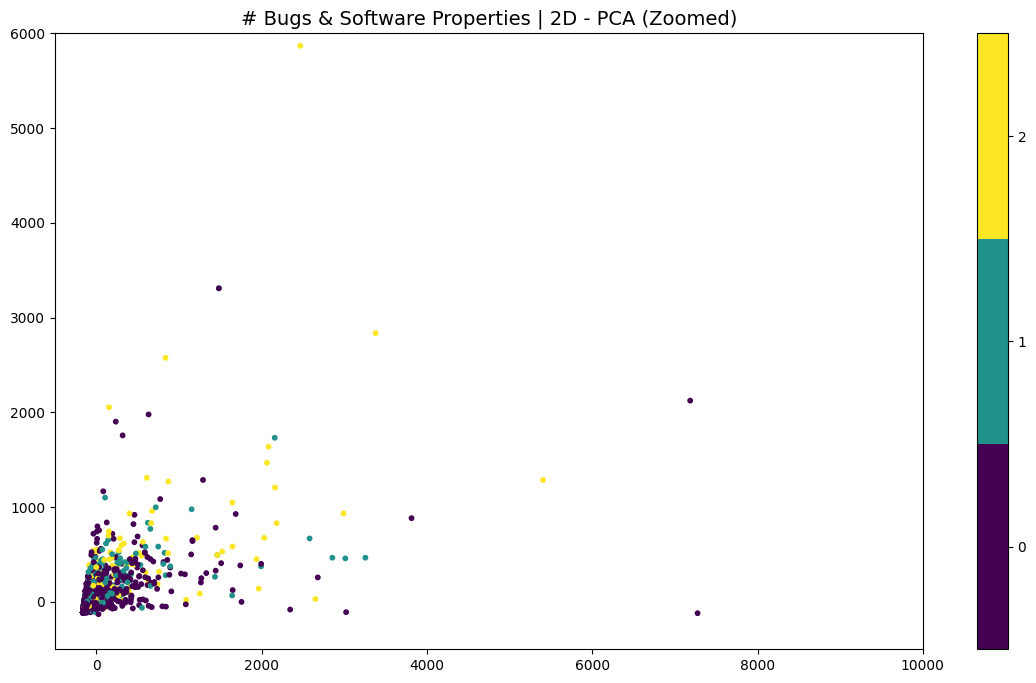

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(principalComponents[0], principalComponents[1], c=y_train, s=10, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(y_train))
ax.set_xlim(-500, 10000);
ax.set_ylim(-500, 6000);

plt.title('# Bugs & Software Properties | 2D - PCA (Zoomed)', fontsize=14);

#### Next Plot is colored by K-Means cluster predictions and not actual values (y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


K-Means Accuracy Score Using PCA: 0.8417132216014898


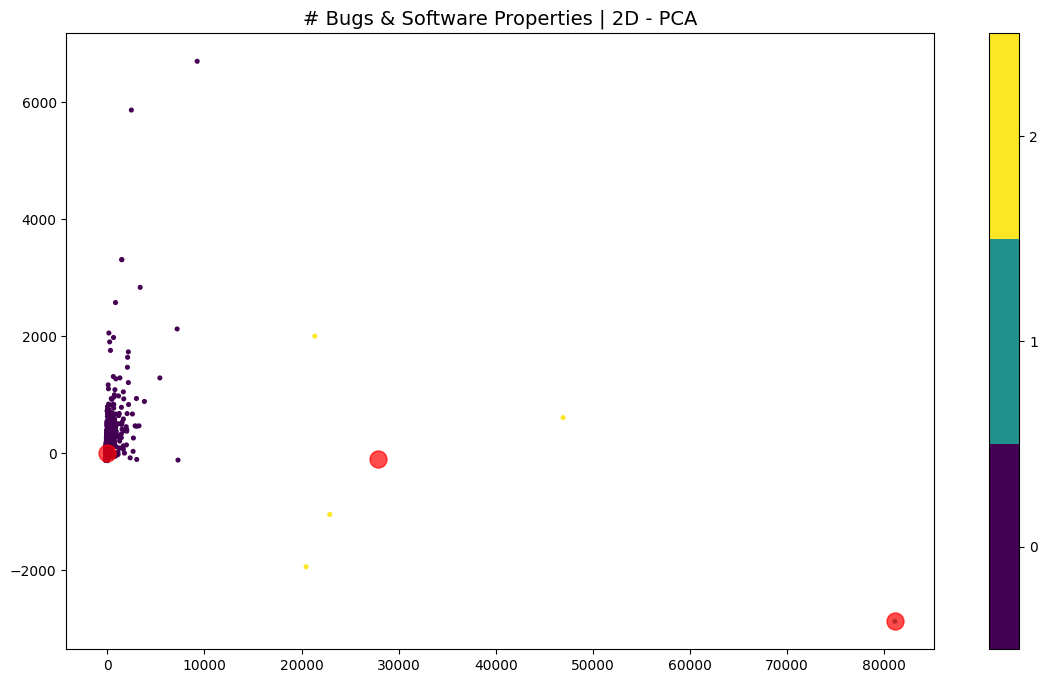

In [ ]:
kmeans_pca = KMeans(n_clusters=3)
kmeans_pca.fit(principalComponents)
preds_kmeans_pca = kmeans_pca.predict(principalComponents)

fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(principalComponents[0], principalComponents[1], c=preds_kmeans_pca, s=7, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(preds_kmeans_pca))

plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], c='red', s=150, alpha=0.7);

# ax.set_xlim(-500, 10000);
# ax.set_ylim(-500, 6000);

plt.title('# Bugs & Software Properties | 2D - PCA', fontsize=14);

print("K-Means Accuracy Score Using PCA:", accuracy_score(preds_kmeans_pca, y_train))

### Note
It is obvious to spot that K-Means had a high accuracy on the training set but definitely not a generalizable one not just because it's on the training set but mainly, for our analysis, it has almost excluded a whole class (**Recall: Notes on class balances in the dataset**) if we took a look at the actualy distribution of classes when if was plotted by actual values after PCA reduction and now with the predicted values from K-Means

# Modeling

#### Models:
- For Multi-Class Classification
    - Random Forest Classifier (Ensemble)
    - K-Nearest Neighbor
    - K-Means (Clustering)

- For Binary Classification
    - AdaBoost (Boosting)
    - Support-Vector Machine
    - Bagging Classifier

- Neural Network (FCNN)

All of these models either:
- need scaling for better generalized results (i.e. SVC, KNN, KMeans, FCNN) as they are distance-based where they are affected by outliers and more importantly (in our case) might favor one feature against another.
- not affected by scaling if the weak learner is a tree-based classifier for AdaBoost, Bagging, or RFC

#### Scale Features seperately in each dataset (NOT the cross validation one; cv dataset should be scaled with each fold in hyper-parameter tuning)

In [ ]:
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

print("Train:", X_train.shape, y_train.shape,
      "Test:", X_test.shape, y_test.shape,
      "Cross Validation", X_cv.shape, y_cv.shape)

Train: (3759, 17) (3759,) Test: (806, 17) (806,) Cross Validation (806, 17) (806,)


#### Modeling Function

In [ ]:
def Modeler(model, X_train, y_train, X_cv, y_cv, params, scale=True, n_jobs=True, pca=False):

    if scale & pca:
        pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('dim_reduct', PCA(n_components=4)),
            ('clf', model())])
        print("Scaling and dim reduct...")

    elif scale:
        pipeline = Pipeline([ ('scale', StandardScaler()), ('clf', model())])

    elif pca:
        pipeline = Pipeline([
        ('dim_reduct', PCA(n_components=pca)),
        ('clf', model())])
    else:
        pipeline = Pipeline([('clf', model())])

    grid = GridSearchCV(pipeline, param_grid = params, cv=3, n_jobs=4, refit=True)
    grid.fit(X_cv, y_cv)

    best_prameters = {}
    for k, v in grid.best_params_.items():
        best_prameters[k[5:]] = v

    if n_jobs:
        model = model(**best_prameters, n_jobs=4)
    else:
        model = model(**best_prameters)

    model.fit(X_train, y_train)

    print("Best Parameters for model:", best_prameters)

    return {
        "model": model,
        "best_params":best_prameters
    }

#### Evaluator Function

#### Note
- We will value all classes in the same way without any dominance from one class on the metric. Therefore, we will use Macro-Averaging for both ROC and F1-Score. This will tell us that our scores will be much lower than expected due to the imbalance (**More details on that at the end**) Event though that ROC is no that sensitive to imbalances, F1-Score can help us a lot here
- We can use AUCROC by one-vs-all Technique

In [ ]:
def model_eval(model, X_test, y_test, acc=True, auc_=True, plot_conf=True, plot_auc=True, multi=True, f1=True, prop=False):

    res = [None, None, None] # Accuracy, auc_roc, f1_score
    y_pred = model.predict(X_test)

    if prop:
        y_pred = np.where(y_pred > 0.5, 1, 0)

    if f1:
        f_sc = f1_score(y_test, y_pred, average='macro')
        res[2] = f_sc

    if acc:
        res[0] = accuracy_score(y_test, y_pred)
#         print('accuracy:', res[0] * 100 ,'%')

    if auc_:
        lb = LabelBinarizer()
        lb.fit(y_test)

        truth = lb.transform(y_test)
        y_pred_encode = lb.transform(y_pred)

        res[1] = roc_auc_score(truth, y_pred_encode, average = 'macro')
#         print('ROC:', res[1] * 100 ,'%')

    if plot_conf:
        fig, ax = plt.subplots(figsize=(10,6))

        conf = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        sns.heatmap(conf, cmap= 'Set1', annot=True, cbar=False)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix');

    if plot_auc:
        fig, ax = plt.subplots(figsize=(10,6))

        if not auc_:
            lb = LabelBinarizer()
            lb.fit(y_test)

            truth = lb.transform(y_test)
            y_pred_encode = lb.transform(y_pred)

        fpr = [None, None, None]
        tpr = [None, None, None]
        auc_of_roc = [None, None, None]

        n_classes = 1 #(0, 1)
        if multi:
            n_classes = 3

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(truth[:, i], y_pred_encode[:, i])
            auc_of_roc[i] = auc(fpr[i], tpr[i])

        plt.plot(fpr[0], tpr[0], label='0 - area under ROC = %0.3f' % auc_of_roc[0])
        if multi:
            plt.plot(fpr[1], tpr[1], label='1 - area under ROC = %0.3f' % auc_of_roc[1])
            plt.plot(fpr[2], tpr[2], label='2 - area under ROC = %0.3f' % auc_of_roc[2])

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("ROC AUC");
        plt.legend()

    return res


#### Under Sampler Function

In [ ]:
def under_sample(X_train, y_train, n=573):
    train_ = pd.concat([X_train, y_train], axis=1)
    df_0 = train_[train_.iloc[:, -1] == 0].sample(n= n)
    df_1 = train_[train_.iloc[:, -1] == 1].sample(n= n)

    train_ = pd.concat([df_0, df_1], axis=0).sample(frac=1.0)
    X_train_under_sampled = train_.iloc[:, 0:-1]
    y_train_under_sampled = train_.iloc[:, -1]
    return X_train_under_sampled, y_train_under_sampled

## Base-Line Classifier
We have to give a better accuracy, roc, or f1-score if we want our classifier to be better than a mere guessing

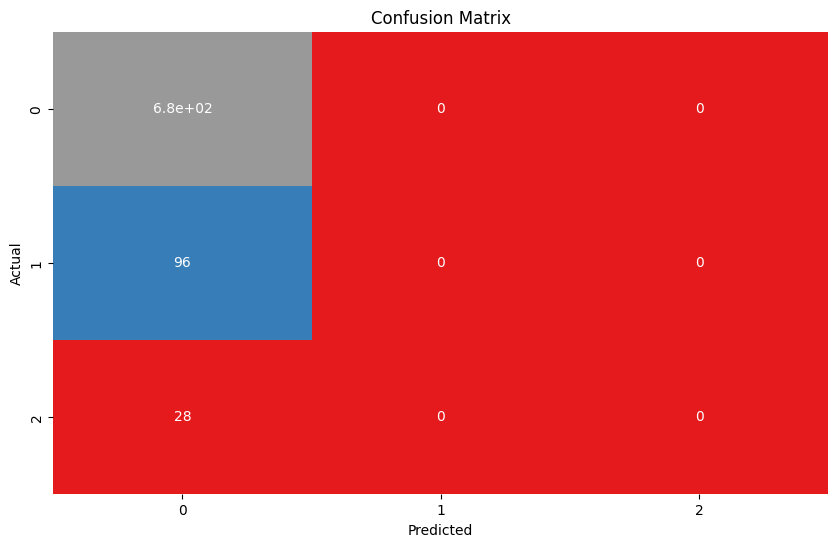

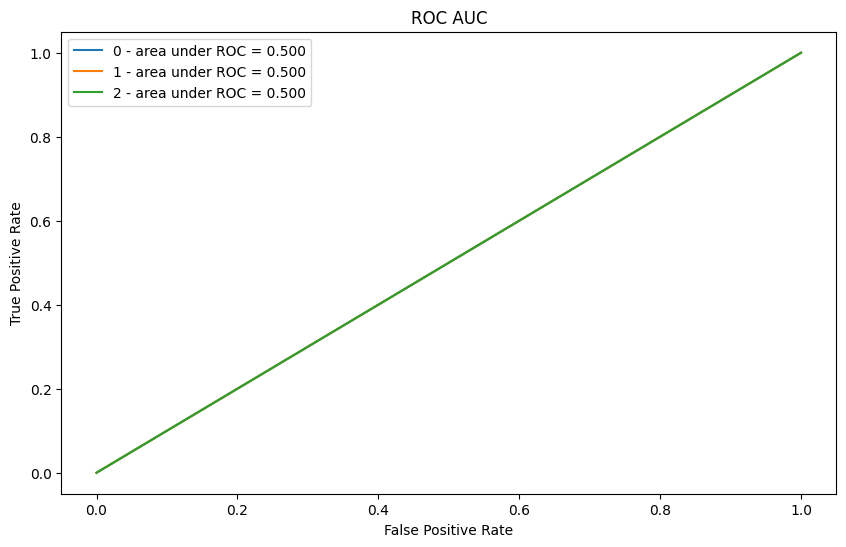

In [ ]:
dmc = DummyClassifier(strategy="most_frequent")
dmc.fit(X_train_scaled, y_train)

model_scoring = model_eval(dmc, X_test_scaled, y_test)

scores = {}
scores["Dummy Classifier | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

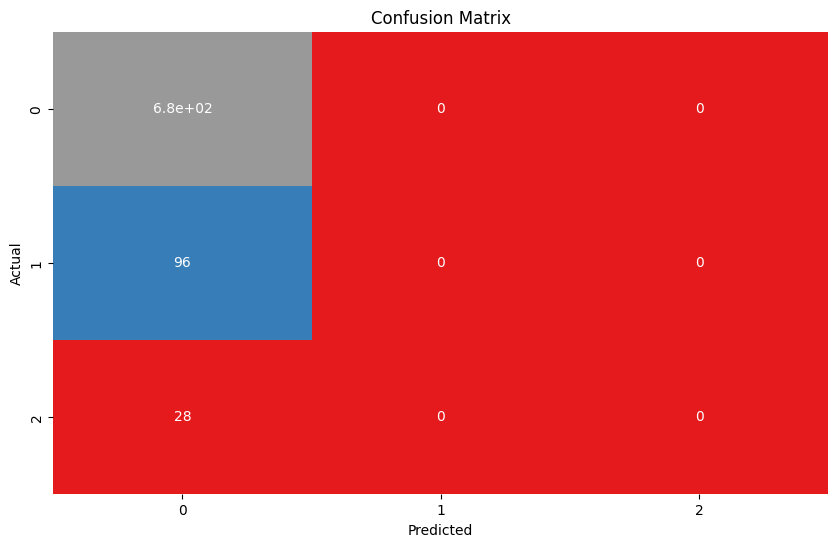

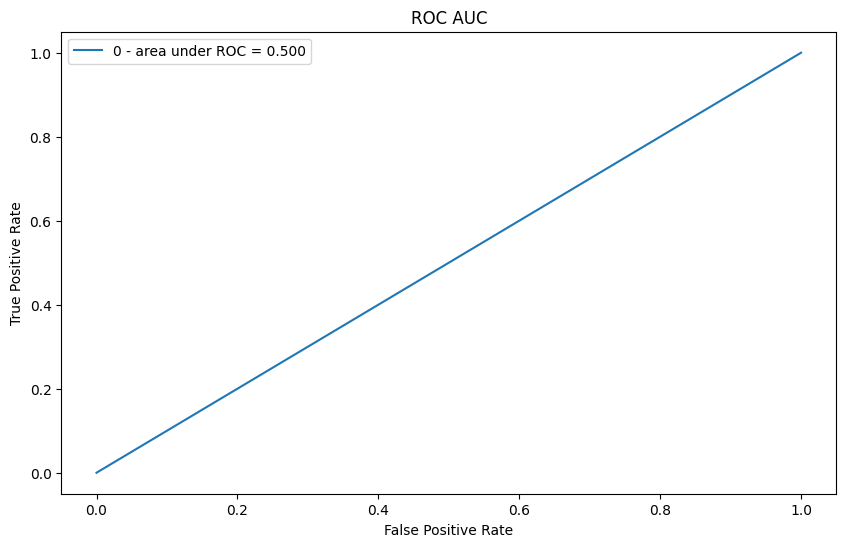

In [ ]:
dmc = DummyClassifier(strategy="most_frequent")
dmc.fit(X_train_scaled, y_train)

model_scoring = model_eval(dmc, X_test_scaled, y_test, multi=False)

scores["Dummy Classifier | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

## Multi-Classifiers

### Random Forest Classifier

In [ ]:
rfc_params = {
    'clf__n_estimators'      : [200, 500, 1000],
    'clf__max_depth'         : [10, 20, 50],
    'clf__max_features': [1.0, 0.7, 0.4],
    'clf__criterion' :['gini', 'entropy']
}

rfc = Modeler(RandomForestClassifier, X_train_scaled, y_train, X_cv, y_cv, rfc_params, scale=True)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters for model: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 1.0, 'n_estimators': 500}


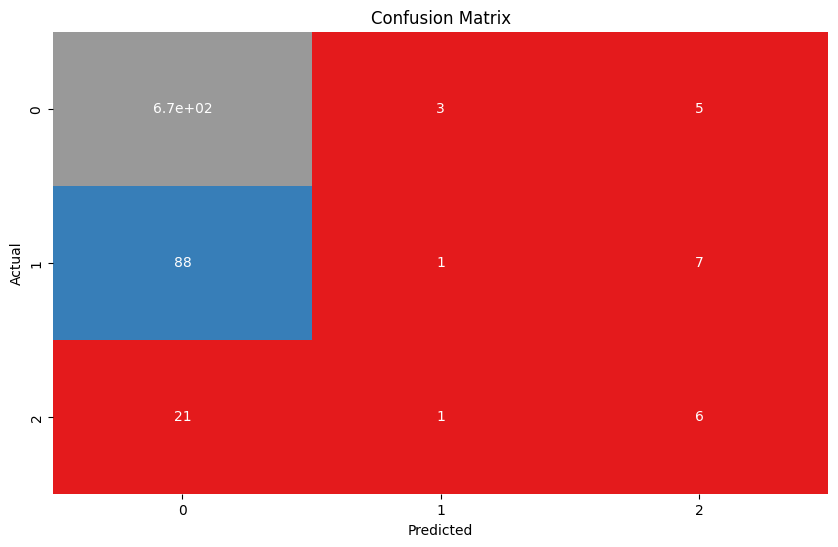

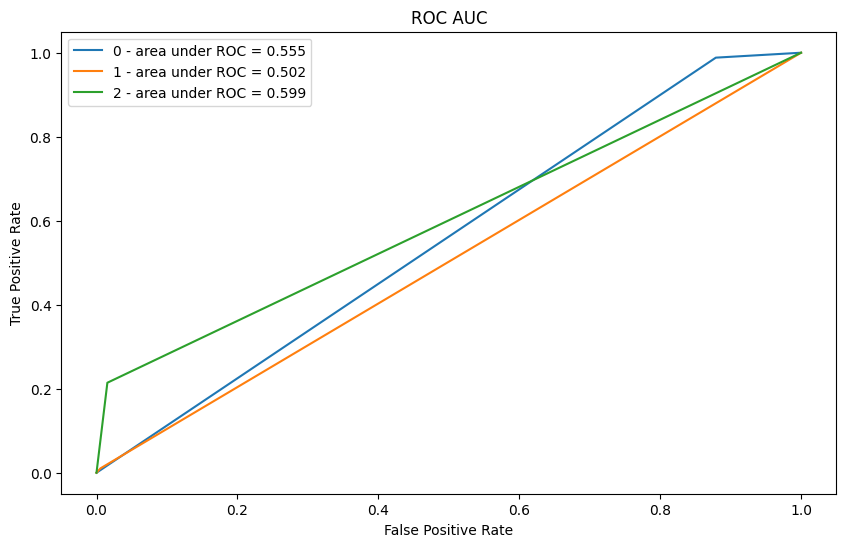

In [ ]:
model_scoring = model_eval(rfc["model"], X_test_scaled, y_test)
scores["Random Forest | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### K-Nearest Neighbor

In [ ]:
knn_params = {
    'clf__n_neighbors': [3, 5, 11, 17],
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan'],
}

knn = Modeler(KNeighborsClassifier, X_train_scaled, y_train, X_cv, y_cv, knn_params, scale=True)

Best Parameters for model: {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}


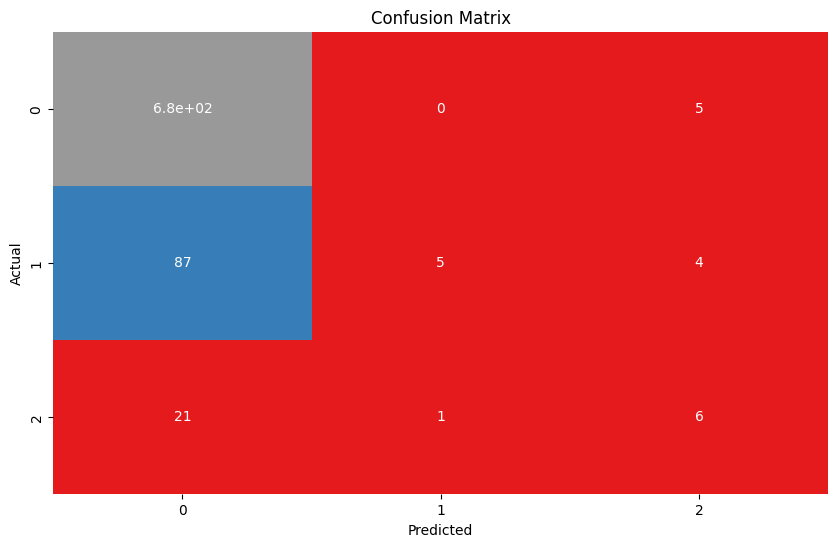

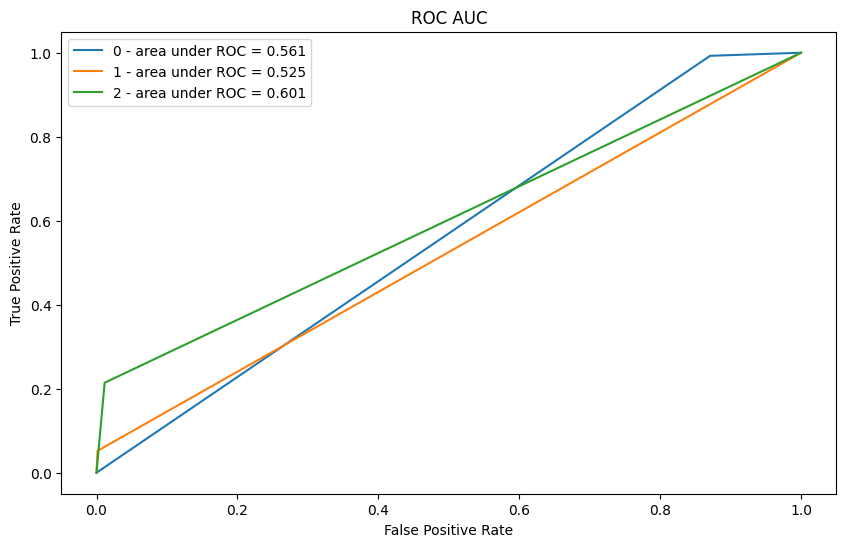

In [ ]:
model_scoring = model_eval(knn["model"], X_test_scaled, y_test)
scores["K-Nearest Neighbor | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

In [ ]:
kmeans_params = {
    'clf__max_iter': [200, 500, 1000],
    'clf__n_init': [10, 30]
}

kmeans = Modeler(KMeans, X_train_scaled, y_train, X_cv, y_cv, kmeans_params, scale=True, n_jobs=False)

Best Parameters for model: {'max_iter': 500, 'n_init': 10}


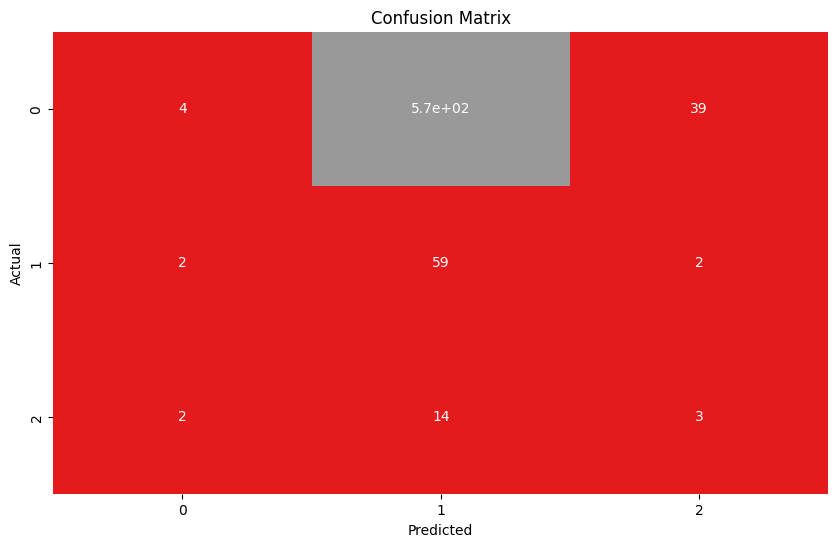

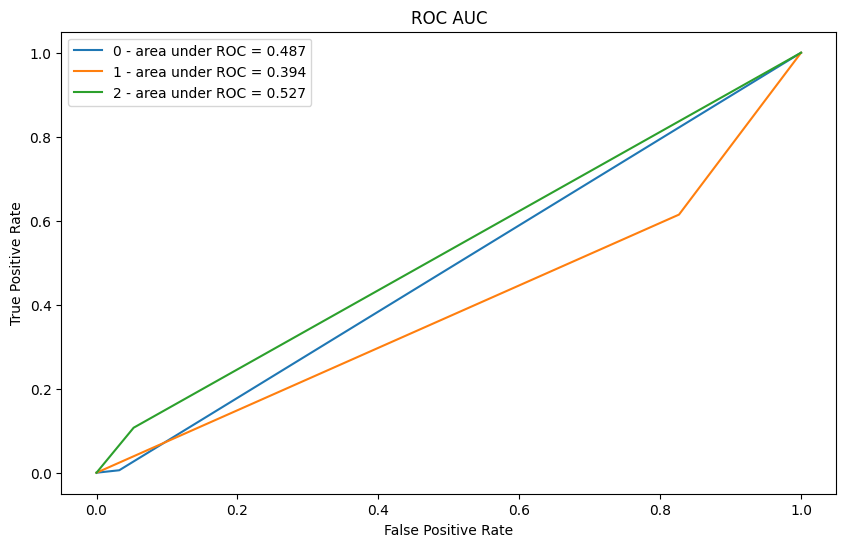

In [ ]:
model_scoring = model_eval(kmeans["model"], X_test_scaled, y_test)
scores["K-Means | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}


### Bagging Classifier (Extra for multi-class)

In [ ]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled, y_train, X_cv, y_cv, bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}


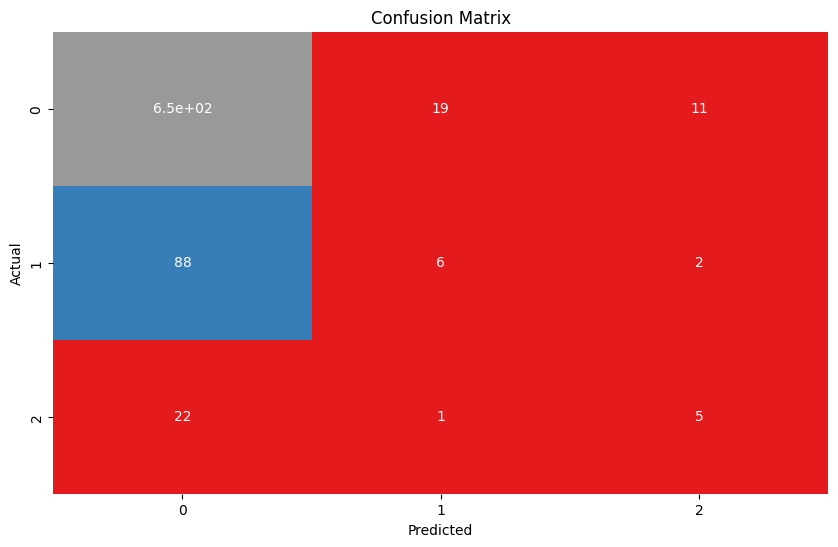

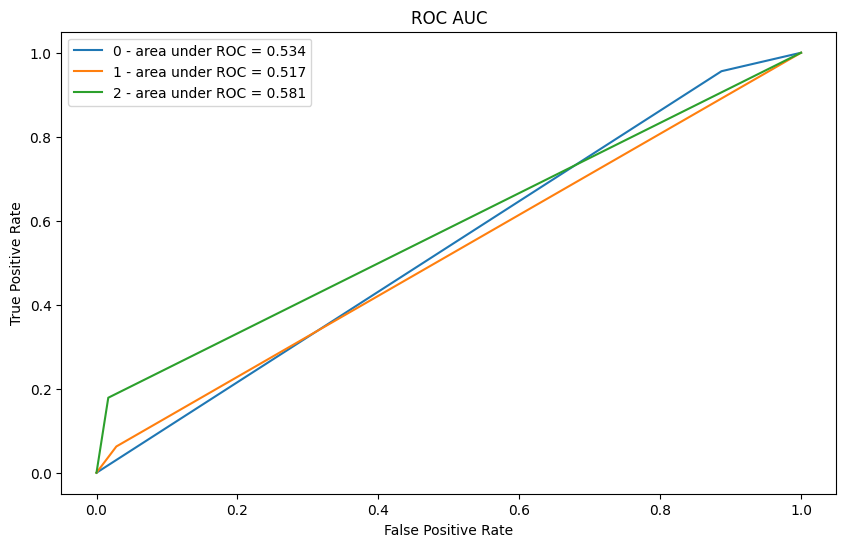

In [ ]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test)
scores["Bagging Classifier | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### Bagging Classifier (with PCA 4D)

In [ ]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled, y_train, X_cv, y_cv, bagg_params, scale=True, pca=4)


Best Parameters for model: {'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.7}


[0.847394540942928, 0.5836563161600624, 0.45386974562511284]

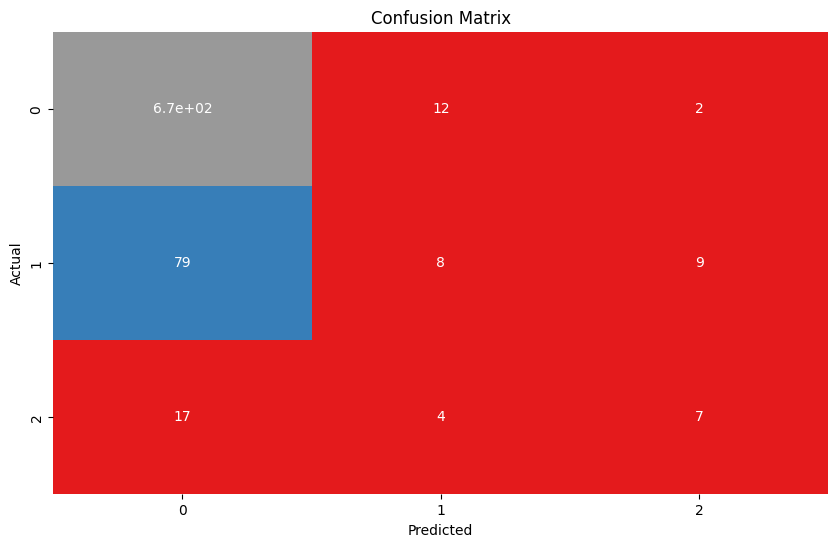

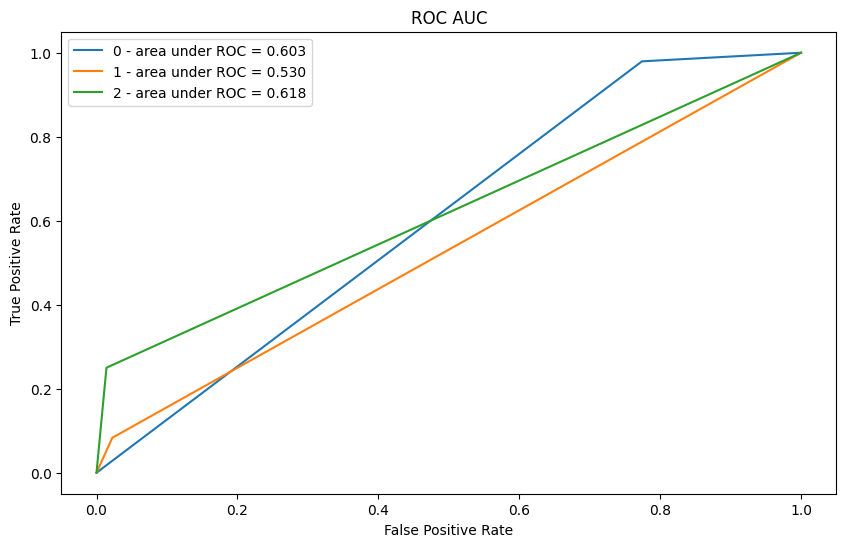

In [ ]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test)

scores["Bagging Classifier | Multi | PCA"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

## Binary-Classifiers

In [ ]:
# We do not need confusing variables such as the class name; We can use it as an index or leave it.
X_binary = df.iloc[:, 1:-2]
y_binary = df["bugs"]

# Warning: Don't Run Twice
idxs1 = y_binary.where(y_binary > 1)
for q in idxs1:
  y_binary = y_binary.replace(q, 1)

print("X:", X.shape)
print("y:", y.shape)

X: (5371, 17)
y: (5371,)


Classes: [0, 1]
Counts: [4518, 853]


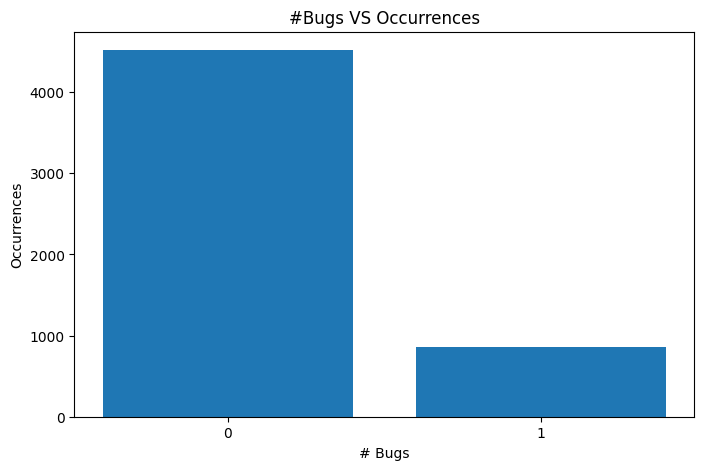

In [ ]:
unique, counts = np.unique(y_binary, return_counts=True)
print("Classes:", unique.tolist())
print("Counts:", counts.tolist())

plt.bar(unique, counts)
plt.title("#Bugs VS Occurrences")
plt.xticks(range(len(unique)))
plt.ylabel("Occurrences")
plt.xlabel("# Bugs");

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.3)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5)
print("Train:", X_train.shape, y_train.shape,
      "Test:", X_test.shape, y_test.shape,
      "Cross Validation", X_cv.shape, y_cv.shape)

X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

Train: (3759, 16) (3759,) Test: (806, 16) (806,) Cross Validation (806, 16) (806,)


#### Warning: X_train, X_test,..., y_cv. has been overridden

### AdaBoost

In [ ]:
# AdaBoostClassifier
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_scaled, y_train, X_cv, y_cv, ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 100}


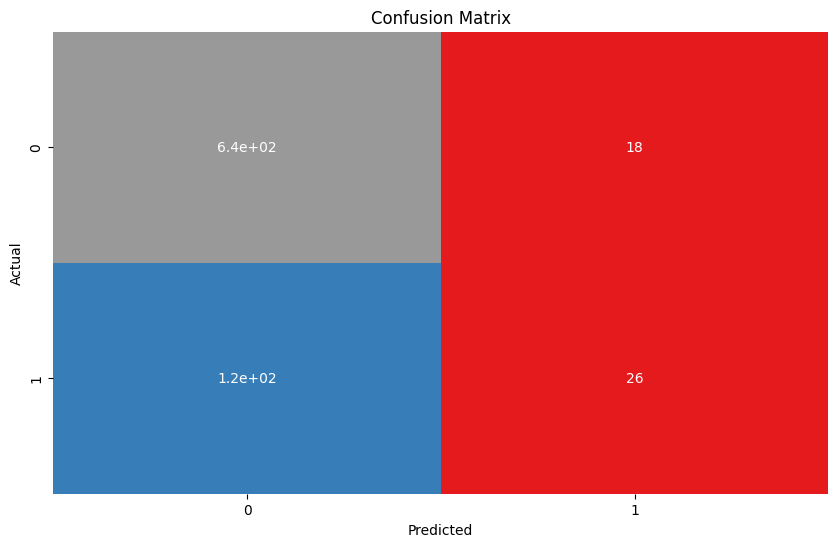

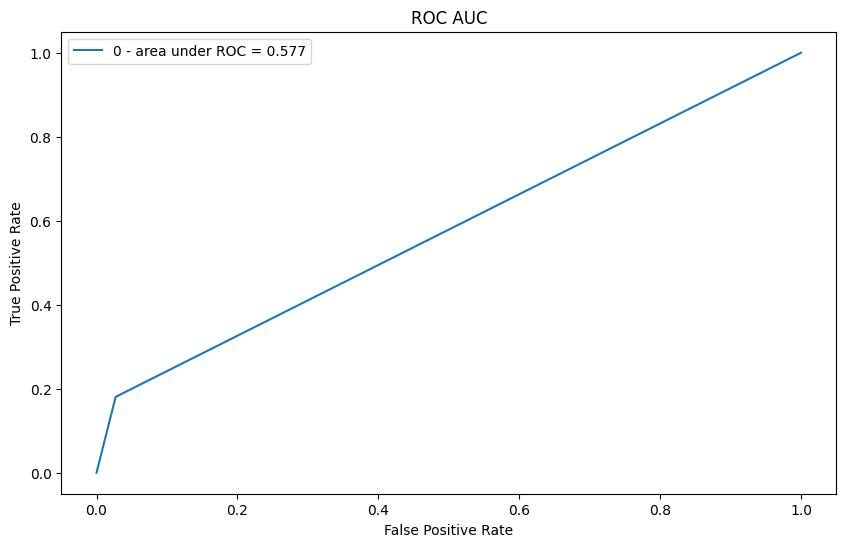

In [ ]:
model_scoring = model_eval(ada["model"], X_test_scaled, y_test, multi=False)
scores["AdaBoost Classifier | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### Support-Vector Machine

In [ ]:
# SVC()
svc_params = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma':[1, 0.01, 0.001]
}

svc = Modeler(SVC, X_train_scaled, y_train, X_cv, y_cv, svc_params, scale=True, n_jobs=False)

Best Parameters for model: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


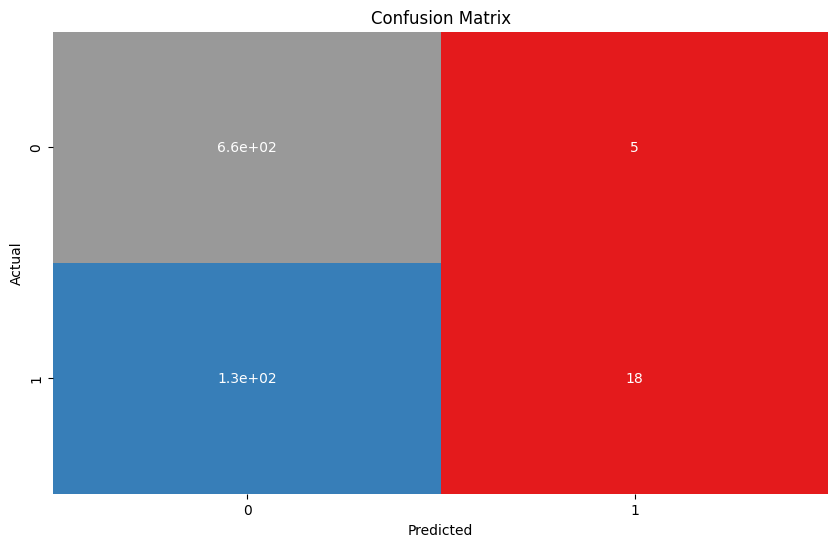

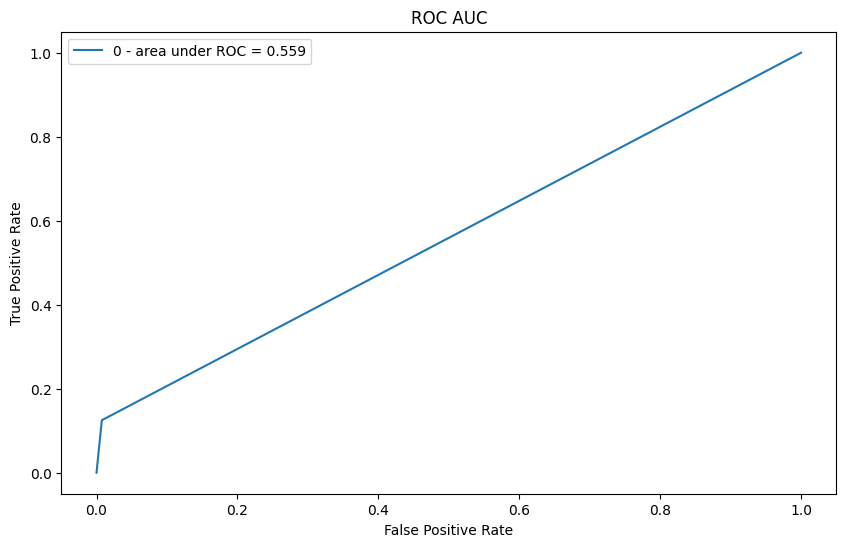

In [ ]:
model_scoring = model_eval(svc["model"], X_test_scaled, y_test, multi=False)
scores["Support-Vector Machine | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### Bagging Classifier

In [ ]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled, y_train, X_cv, y_cv, bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.7}


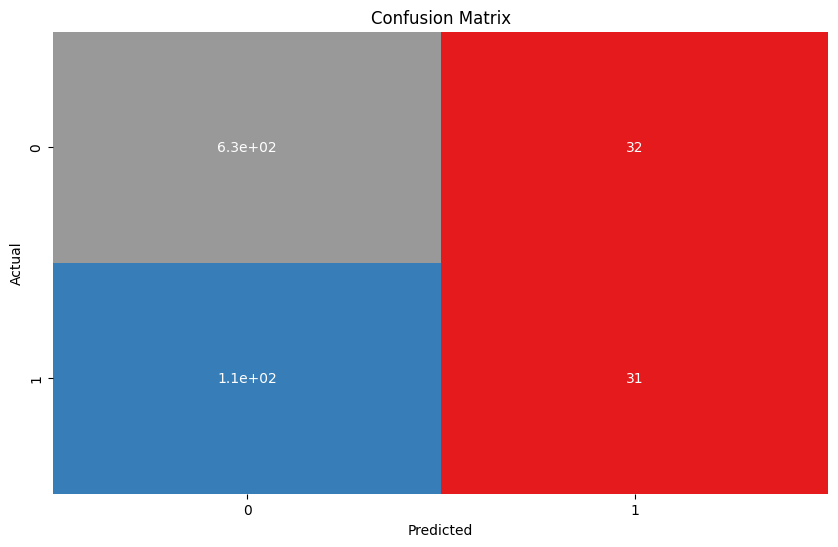

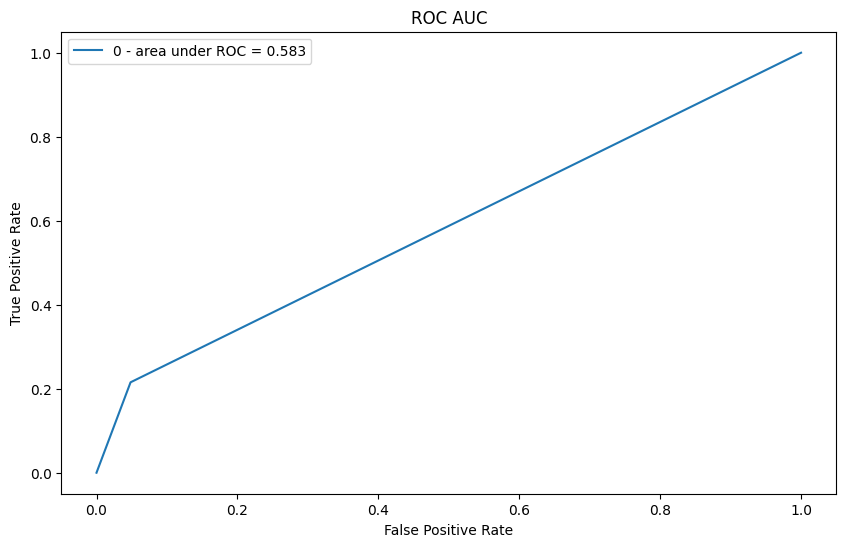

In [ ]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test, multi=False)
scores["Bagging Classifier | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

#### Note:
All models achieved a similar or less auc rocs/f1 without scaling (tried it for a sanity check)

In [ ]:
score_df = pd.DataFrame.from_dict(scores).T
score_df= score_df.sort_values('ROC', ascending=False)

In [ ]:
score_df

,Accuracy,ROC,F1-Score
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.453870
Bagging Classifier | Binary,0.820099,0.583470,0.598157
AdaBoost Classifier | Binary,0.831266,0.576683,0.590545
K-Nearest Neighbor | Multi,0.853598,0.562516,0.433360
Support-Vector Machine | Binary,0.837469,0.558724,0.562456
Random Forest | Multi,0.844913,0.552147,0.400269
Bagging Classifier | Multi,0.822581,0.544185,0.406266
Dummy Classifier | Multi,0.846154,0.500000,0.305556
Dummy Classifier | Binary,0.846154,0.500000,0.305556
K-Means | Multi,0.081886,0.469312,0.036280


# Data-Driven Model Optimization

##### Pick the 3 highest models

## Under Sampling

Redcuing the number of samples in the majority class randomly so that the two classes are balanced and then testing it on an imbalanced real-world-like dataset (test set)

In [ ]:
X_train_under_sampled, y_train_under_sampled = under_sample(X_train_scaled, y_train, n=(y_train==1).sum())

#### AdaBoost

In [ ]:
# X_cv_scaled = pd.DataFrame(StandardScaler().fit_transform(X_cv.values), columns=X_cv.columns, index=X_cv.index)
X_cv_under_sampled, y_cv_under_sampled = under_sample(X_cv, y_cv, n=(y_cv == 1).sum())

ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_under_sampled, y_train_under_sampled, X_cv_under_sampled, y_cv_under_sampled,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
model_scoring = model_eval(ada["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Usam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.7109181141439206, 0.671869754951326, 0.6183176939476899]

#### Bagging Classifier

In [ ]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_under_sampled, y_train_under_sampled, X_cv_under_sampled, y_cv_under_sampled,
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.3}


In [ ]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Usam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.6774193548387096, 0.6406092648539781, 0.5864643849456934]

In [ ]:
score_df = pd.DataFrame.from_dict(scores).T
score_df= score_df.sort_values('ROC', ascending=False)

In [ ]:
score_df

,Accuracy,ROC,F1-Score
AdaBoost Classifier | Binary | Usam,0.710918,0.671870,0.618318
Bagging Classifier | Binary | Usam,0.677419,0.640609,0.586464
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.453870
Bagging Classifier | Binary,0.820099,0.583470,0.598157
AdaBoost Classifier | Binary,0.831266,0.576683,0.590545
K-Nearest Neighbor | Multi,0.853598,0.562516,0.433360
Support-Vector Machine | Binary,0.837469,0.558724,0.562456
Random Forest | Multi,0.844913,0.552147,0.400269
Bagging Classifier | Multi,0.822581,0.544185,0.406266
Dummy Classifier | Multi,0.846154,0.500000,0.305556


## Over Sampling

In [ ]:
from imblearn.over_sampling import SMOTE
X_train_over_sampled, y_train_over_sampled = SMOTE().fit_resample(X_train_scaled, y_train)
X_cv_over_sampled, y_cv_over_sampled = SMOTE().fit_resample(X_cv, y_cv)

In [ ]:

X_train_over_sampled = pd.DataFrame(X_train_over_sampled)
X_cv_over_sampled = pd.DataFrame(X_cv_over_sampled)

y_train_over_sampled = pd.Series(y_train_over_sampled)
y_cv_over_sampled = pd.Series(y_cv_over_sampled)

#### AdaBoost

In [ ]:
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_over_sampled, y_train_over_sampled, X_cv_over_sampled, y_cv_over_sampled,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 1.0, 'n_estimators': 200}


In [ ]:
model_scoring = model_eval(ada["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Osam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.18238213399503722, 0.49954892581403154, 0.15731975282200167]

#### Bagging Classifier

In [ ]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_over_sampled, y_train_over_sampled, X_cv_over_sampled, y_cv_over_sampled,
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}


In [ ]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Osam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.22580645161290322, 0.5042484894259819, 0.21646632143725114]

In [ ]:
score_df = pd.DataFrame.from_dict(scores).T
score_df= score_df.sort_values('ROC', ascending=False)

In [ ]:
score_df

,Accuracy,ROC,F1-Score
AdaBoost Classifier | Binary | Usam,0.710918,0.671870,0.618318
Bagging Classifier | Binary | Usam,0.677419,0.640609,0.586464
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.453870
Bagging Classifier | Binary,0.820099,0.583470,0.598157
AdaBoost Classifier | Binary,0.831266,0.576683,0.590545
K-Nearest Neighbor | Multi,0.853598,0.562516,0.433360
Support-Vector Machine | Binary,0.837469,0.558724,0.562456
Random Forest | Multi,0.844913,0.552147,0.400269
Bagging Classifier | Multi,0.822581,0.544185,0.406266
Bagging Classifier | Binary | Osam,0.225806,0.504248,0.216466


## With Feature Selection

#### Refer back to feature selection above, features selected were:
    - rfc
    - cbo
    - fanOut
    - wmc
    - numberOfLinesOfCode

In [ ]:
X_train_scaled_featured = X_train_scaled[['rfc', 'cbo', 'fanOut', 'numberOfLinesOfCode']]
X_test_scaled_featured = X_test_scaled[['rfc', 'cbo', 'fanOut', 'numberOfLinesOfCode']]
X_cv_featured = X_cv[['rfc', 'cbo', 'fanOut', 'numberOfLinesOfCode']]

X_train_scaled_featured_underS = X_train_under_sampled[['rfc', 'cbo', 'fanOut', 'numberOfLinesOfCode']]
X_cv_featured_underS = X_cv_under_sampled[['rfc', 'cbo', 'fanOut', 'numberOfLinesOfCode']]

In [ ]:
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_scaled_featured, y_train, X_cv_featured, y_cv,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
model_scoring = model_eval(ada["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Featured"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.8374689826302729, 0.5695913058073179, 0.5801332140371807]

In [ ]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled_featured, y_train, X_cv_featured, y_cv,
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.3}


In [ ]:
model_scoring = model_eval(bagg["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Featured"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.8287841191066998, 0.5588704263175562, 0.5642423957500822]

#### Feature Selection with Under Sampling

In [ ]:
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_scaled_featured_underS, y_train_under_sampled, X_cv_featured_underS, y_cv_under_sampled,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
model_scoring = model_eval(ada["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Featured | USam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.728287841191067, 0.6416897448808324, 0.6121892542101043]

In [ ]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled_featured_underS, y_train_under_sampled, X_cv_featured_underS, y_cv_under_sampled,
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.3}


In [ ]:
model_scoring = model_eval(bagg["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Featured | USam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.6066997518610422, 0.5731054884189326, 0.522171624136222]

# Model Quality Metric Table

In [ ]:
score_df = pd.DataFrame.from_dict(scores).T

In [ ]:
multi_clf_scores = score_df[(score_df.index.str.contains('Multi'))]
binary_clf_scores = score_df[(score_df.index.str.contains('Binary') == True)]

#### Base-Line

In [ ]:
score_df[(score_df.index.str.contains('Dummy'))]

,Accuracy,ROC,F1-Score
Dummy Classifier | Multi,0.846154,0.5,0.305556
Dummy Classifier | Binary,0.846154,0.5,0.305556


## Multi-Classifiers

#### By accuracy

In [ ]:
multi_clf_scores.sort_values('Accuracy', ascending=False)

,Accuracy,ROC,F1-Score
K-Nearest Neighbor | Multi,0.853598,0.562516,0.433360
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.453870
Dummy Classifier | Multi,0.846154,0.500000,0.305556
Random Forest | Multi,0.844913,0.552147,0.400269
Bagging Classifier | Multi,0.822581,0.544185,0.406266
K-Means | Multi,0.081886,0.469312,0.036280


#### By ROC

In [ ]:
multi_clf_scores.sort_values('ROC', ascending=False)

,Accuracy,ROC,F1-Score
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.453870
K-Nearest Neighbor | Multi,0.853598,0.562516,0.433360
Random Forest | Multi,0.844913,0.552147,0.400269
Bagging Classifier | Multi,0.822581,0.544185,0.406266
Dummy Classifier | Multi,0.846154,0.500000,0.305556
K-Means | Multi,0.081886,0.469312,0.036280


#### By F1-Score

In [ ]:
multi_clf_scores.sort_values('F1-Score', ascending=False)

,Accuracy,ROC,F1-Score
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.453870
K-Nearest Neighbor | Multi,0.853598,0.562516,0.433360
Bagging Classifier | Multi,0.822581,0.544185,0.406266
Random Forest | Multi,0.844913,0.552147,0.400269
Dummy Classifier | Multi,0.846154,0.500000,0.305556
K-Means | Multi,0.081886,0.469312,0.036280


#### Best in Accuracy

In [ ]:
multi_clf_scores.sort_values('Accuracy', ascending=False).iloc[:1,:]

,Accuracy,ROC,F1-Score
K-Nearest Neighbor | Multi,0.853598,0.562516,0.43336


#### Best in ROC

In [ ]:
multi_clf_scores.sort_values('ROC', ascending=False).iloc[:1,:]

,Accuracy,ROC,F1-Score
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.45387


#### Best in F1-Score

In [ ]:
multi_clf_scores.sort_values('F1-Score', ascending=False).iloc[:1,:]

,Accuracy,ROC,F1-Score
Bagging Classifier | Multi | PCA,0.847395,0.583656,0.45387


## Binary Classifiers

#### By Accuracy

In [ ]:
binary_clf_scores.sort_values('Accuracy', ascending=False)

,Accuracy,ROC,F1-Score
Dummy Classifier | Binary,0.846154,0.500000,0.305556
Support-Vector Machine | Binary,0.837469,0.558724,0.562456
AdaBoost Classifier | Binary | Featured,0.837469,0.569591,0.580133
AdaBoost Classifier | Binary,0.831266,0.576683,0.590545
Bagging Classifier | Binary | Featured,0.828784,0.558870,0.564242
Bagging Classifier | Binary,0.820099,0.583470,0.598157
AdaBoost Classifier | Binary | Featured | USam,0.728288,0.641690,0.612189
AdaBoost Classifier | Binary | Usam,0.710918,0.671870,0.618318
Bagging Classifier | Binary | Usam,0.677419,0.640609,0.586464
Bagging Classifier | Binary | Featured | USam,0.606700,0.573105,0.522172


#### By ROC

In [ ]:
binary_clf_scores.sort_values('ROC', ascending=False)

,Accuracy,ROC,F1-Score
AdaBoost Classifier | Binary | Usam,0.710918,0.671870,0.618318
AdaBoost Classifier | Binary | Featured | USam,0.728288,0.641690,0.612189
Bagging Classifier | Binary | Usam,0.677419,0.640609,0.586464
Bagging Classifier | Binary,0.820099,0.583470,0.598157
AdaBoost Classifier | Binary,0.831266,0.576683,0.590545
Bagging Classifier | Binary | Featured | USam,0.606700,0.573105,0.522172
AdaBoost Classifier | Binary | Featured,0.837469,0.569591,0.580133
Bagging Classifier | Binary | Featured,0.828784,0.558870,0.564242
Support-Vector Machine | Binary,0.837469,0.558724,0.562456
Bagging Classifier | Binary | Osam,0.225806,0.504248,0.216466


#### By F1-Score

In [ ]:
binary_clf_scores.sort_values('F1-Score', ascending=False)

,Accuracy,ROC,F1-Score
AdaBoost Classifier | Binary | Usam,0.710918,0.671870,0.618318
AdaBoost Classifier | Binary | Featured | USam,0.728288,0.641690,0.612189
Bagging Classifier | Binary,0.820099,0.583470,0.598157
AdaBoost Classifier | Binary,0.831266,0.576683,0.590545
Bagging Classifier | Binary | Usam,0.677419,0.640609,0.586464
AdaBoost Classifier | Binary | Featured,0.837469,0.569591,0.580133
Bagging Classifier | Binary | Featured,0.828784,0.558870,0.564242
Support-Vector Machine | Binary,0.837469,0.558724,0.562456
Bagging Classifier | Binary | Featured | USam,0.606700,0.573105,0.522172
Dummy Classifier | Binary,0.846154,0.500000,0.305556


#### Best in Accuracy

In [ ]:
binary_clf_scores.sort_values('Accuracy', ascending=False).iloc[:1,:]

,Accuracy,ROC,F1-Score
Dummy Classifier | Binary,0.846154,0.5,0.305556


#### Best in ROC

In [ ]:
binary_clf_scores.sort_values('ROC', ascending=False).iloc[:1,:]

,Accuracy,ROC,F1-Score
AdaBoost Classifier | Binary | Usam,0.710918,0.67187,0.618318


#### Best in F1-Score

In [ ]:
binary_clf_scores.sort_values('F1-Score', ascending=False).iloc[:1,:]

,Accuracy,ROC,F1-Score
AdaBoost Classifier | Binary | Usam,0.710918,0.67187,0.618318


### Notes

##### F1-Score uses macro-averaging:
This is a way to ensure that we're giving a fair weight (i.e. decrease the total metric score when the lower-in-size class is misclassified). This choice was made to ensure that classifying 0 bugs when there are actually 1 or more bugs is extremely unwanted in the real world (e.g. predicting NO cancerous cells - majority - when there're cancerous cells is considered a false-negative which is dangerous). Here, the negative class is having a bug > 0. Releasing the software with a false knowledge that there are no bugs creats an issue, in a sense, Misclassifying a negative sample would be detrimental to business.
      
      
      
##### PCA:
Note that most of the models were trained with/out pca but not added due to the large number of unending combinations (7 classifiers x hyper-parameter tuning combinations x 2 (for pca) x 2 (for umap)).
      
      
  
##### Under Sampling
Under sampling is a technique in which we randomly draw without replacement **n** sample from the majority class where **n = full samples in the minority class** to solve the imbalance in the training dataset where the classifier can focus on both classes without falling into a biased measurements towards one class over another. Then we test it on an unchaged real-world imbalanced dataset and check whether the model has achieved an accepted classifications for each class. we can see the improvement after applying this technique.



##### Over Sampling
The opposite of under sampling in which we focus our attention on the less abundant class and synthesize some extra points for it. This is done when we talk about SMOT (Synthetic Minority Over-sampling Technique) by taking a sample from the minority class and get the k-nearest neighbors of that sample, draw a vector between the sample and the k-nearest point, multiply it by a random number and add this point to the dataset.
        
        
        
##### AdaBoost
This is one of the classifiers that also helps with this imbalanced dataset as it uses a technique in which it adds more weight to the samples that were incorrectly classified after the initialization of equal weights for all samples (classifier's weight alpha that is based on the error rate of a chosen sample). Now with the class that was incorrectly classified in this imbalanced dataset, the model will focus on these ones more.